In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Input, Activation, Dropout, BatchNormalization, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.regularizers import l2, l1

import yfinance as yf
import statsmodels as sms
import statsmodels.api as sm

pd.set_option('display.max_rows',60000)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth',200)
pd.options.display.float_format = '{:,.10f}'.format
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class myStock(object):
    def __init__(self, ticker, df ):
        '''Load the file via input_dict'''
        self.my_stock = df
        self.ticker = ticker
        self.ticker_df = None
        self.n_steps = 80
        self.features = None

        self.fetch_ticker()
        self.X_train, self.y_train, self.X_test, self.y_test, self.X_val, self.y_val = None,None,None,None,None,None
        self.split_scale_transform()

    def fetch_ticker(self):
        '''this function helps with fetching and cleaning of the stock'''
        my_ticker = self.my_stock[self.my_stock['ticker_id'] == self.ticker ].reset_index(drop=True)
        ticker_df = my_ticker[['volatility_atr_relative_pctc',
       'macd_sig_line_relative_close_pctc', 'macd_relative_close_pctc',
       'beta_close_relative_pctc', 'tr_relative_pctc', 'open_close_pctc',
       'volatility_bbm_relative', 'volatility_bbh_relative', 'momentum_rsi',
       'momentum_rsi_relative_pctc', 'pe_ratio_pctc', 'volatility_bb_width',
       'earnings_date_flag', 'beta_vol_interaction_pctc', 'rolling_beta',
       'beta_close_pctc', 'beta_vol_interaction', 'vix', 'volume_pctc',
       'volatility_bb_width_pctc','close_pctc']].copy()

        self.ticker_df = ticker_df
        self.features = ticker_df.shape[1] - 1

    def plot_ (self):
        '''this function produces a simple plot of the stock'''
        self.ticker_df[['price','open']].plot(figsize=(16, 4), title = '{} stock'.format(self.ticker));

    def basic_stats(self):
        '''this is to print the .describe of the dataframe. For quick view of the basic statistics of the df'''
        print('df shape:','{} rows and {} columns'.format(self.ticker_df.shape[0],self.ticker_df.shape[1]))
        display(self.ticker_df.describe())

    def return_rmse(self, test, predicted):
        '''this is a reusable code to compute rmse'''
        rmse = np.sqrt(mean_squared_error(test, predicted))
        print("The root mean squared error is {:.2f}.".format(rmse))
        return(rmse)

    def build_baseline(self):
        '''this is to build a baseline model'''
        y_base = self.ticker_df['open'].values
        mean_baseline_pred = np.mean(y_base)
        pred_baseline = np.full(shape=len(y_base), fill_value=mean_baseline_pred)
        self.return_rmse(y_base, pred_baseline)

    def split_sequence(self, sequence):
        '''this is the main function to split a sequence into the x and y.
        as a form of simple explanation, the first x observation will contain first 60 rows of 4 features,
        and the first y observation will contain the 61st row of the opening price
        code is written to allow efficiency and consistency'''
        X, y = [],[]
        for i in range(len(sequence)):
            end_ix = i + self.n_steps
            if end_ix > len(sequence) - 1:
                break
            #code is written to allow efficiency and consistency
            seq_x, seq_y = sequence[i:end_ix,:self.features], sequence[end_ix][-1]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    def split_scale_transform(self):
        '''contains a straight-through train-test split and scaling function'''
        # Calculate the no. of entries for each split
        # set the train size as 70%, val size as 15%, all remaining to go to test_size
        total_entries = len(self.ticker_df)
        train_size = int(total_entries * 0.6)
        test_size = int(total_entries * 0.20)
        val_size = total_entries - train_size - test_size

        # Split the df into training, validation, and test sets
        train_df = self.ticker_df.iloc[:train_size].values
        test_df = self.ticker_df.iloc[train_size:train_size+test_size].values
        self.val_df = self.ticker_df.iloc[train_size+test_size:].values

        print(f"Training set size: {train_df.shape}")
        print(f"Test set size: {test_df.shape}")
        print(f"Validation set size: {self.val_df.shape}")

        from sklearn.preprocessing import MinMaxScaler
        self.scaler = MinMaxScaler()

        train_scaled = self.scaler.fit_transform(train_df)
        test_scaled = self.scaler.transform(test_df)
        val_scaled = self.scaler.transform(self.val_df)

        # split into train,test and val samples
        self.X_train, self.y_train = self.split_sequence(train_scaled)
        self.X_test, self.y_test = self.split_sequence(test_scaled)
        self.X_val, self.y_val = self.split_sequence(val_scaled)

        self.print_done()

    def print_done(self):
        print('process complete')

class myModel(myStock):
    def __init__(self, ticker, df):
        '''Initialize the myModel class and build the model'''
        self.model = None
        self.model_name = None
        self.best_hps = None
        self.best_epoch = None
        self.actual_values = None  # Stores actual test set values
        self.predicted_values = None  # Stores predicted values
        self.export_df = pd.DataFrame()
        super(myModel, self).__init__(ticker, df )  # Initialize parent class
        self.build_model()  # Automatically build model on initialization

    def build_model(self):
        '''Builds and compiles the LSTM model'''
        if self.features is None:
            raise ValueError("Features were not properly initialized. Check 'fetch_ticker()' execution.")

        self.model = Sequential()

        # Input Layer
        self.model.add(Input(shape=(self.n_steps, self.features)))

        # First LSTM layer
        self.model.add(LSTM(units=192, activation="tanh", return_sequences=True,
                            kernel_regularizer=l2(0.0002755494166120408)))

        # Second LSTM layer
        self.model.add(LSTM(units=128, activation="tanh", return_sequences=False,
                            kernel_regularizer=l2(0.00011232442362522289)))

        # Dropout for input layer
        self.model.add(Dropout(0.6))

        # First Dense layer
        self.model.add(Dense(192, activation="tanh", kernel_regularizer=l2(0.004123594541658468)))

        # Batch Normalization
        self.model.add(BatchNormalization())

        # Second Dense layer
        self.model.add(Dense(64, activation="tanh", kernel_regularizer=l2(0.0010844957234939668)))
        self.model.add(BatchNormalization())

        # Third Dense layer
        self.model.add(Dense(128, activation="tanh", kernel_regularizer=l2(0.0017768146076875368)))
        self.model.add(BatchNormalization())

        # Output layer
        self.model.add(Dense(1))

        # Compile Model
        optimizer_setting = RMSprop(learning_rate=9.081842147321761e-05)
        self.model.compile(optimizer=optimizer_setting, loss="mse", metrics=["mae"])

        print("Model built and compiled successfully!")

    def training(self, epochs, batch_size, verbose, title_):
        '''Train the model on the dataset'''
        if self.model is None:
            raise ValueError("Model is not initialized. Call 'build_model()' first.")

        self.model_name = title_

        history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size,
                                 validation_data=(self.X_test, self.y_test), verbose=verbose)

        history_df = pd.DataFrame(history.history)
        history_df[['loss','val_loss']].plot(figsize=(16, 4), grid=True,
                                             title='Loss v Val_loss for {} Model'.format(title_))

        return history_df

    def plot_predictions(self, test, predicted):
        '''Plots the real and predicted price visually'''
        plt.figure(figsize=(16, 4))
        plt.plot(test, color="gray", label="Real")
        plt.plot(predicted, color="red", label="Predicted")
        plt.title("{} Stock Price Prediction for {}".format(self.ticker, self.model_name))
        plt.xlabel("Time")
        plt.ylabel("{} Stock Price".format(self.ticker))
        plt.legend()
        plt.show()

    def evaluate(self):
        '''Inverse the predicted arrays back into the correct price range
           and compute the error rate between actual and predicted prices'''
        if self.model is None:
            raise ValueError("Model is not initialized. Call 'build_model()' first.")

        predicted_stock_price = self.model.predict(self.X_val)

        # Ensure correct shape for inverse transformation
        dummy_array = np.zeros((predicted_stock_price.shape[0], self.ticker_df.shape[1]))
        dummy_array[:, -1] = predicted_stock_price[:, 0] if len(predicted_stock_price.shape) > 1 else predicted_stock_price
        inversed_dummy_array = self.scaler.inverse_transform(dummy_array)
        self.predicted_values = inversed_dummy_array[:, -1]  # Save predicted values

        self.actual_values = self.val_df[self.n_steps:, -1]  # Save actual test values

        # Plot and compute RMSE
        self.plot_predictions(self.actual_values, self.predicted_values)

        self.export_df['actual_values'] = self.actual_values
        self.export_df['predicted_values'] = self.predicted_values
        self.export_df['ticker'] = self.ticker

        print("Predictions saved. Access via `self.predicted_values` and `self.actual_values`.")


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/projects_fp/dataset_250222_run.csv')

stock_tickers = list(df['ticker_id'].unique())


Processing stock: T
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


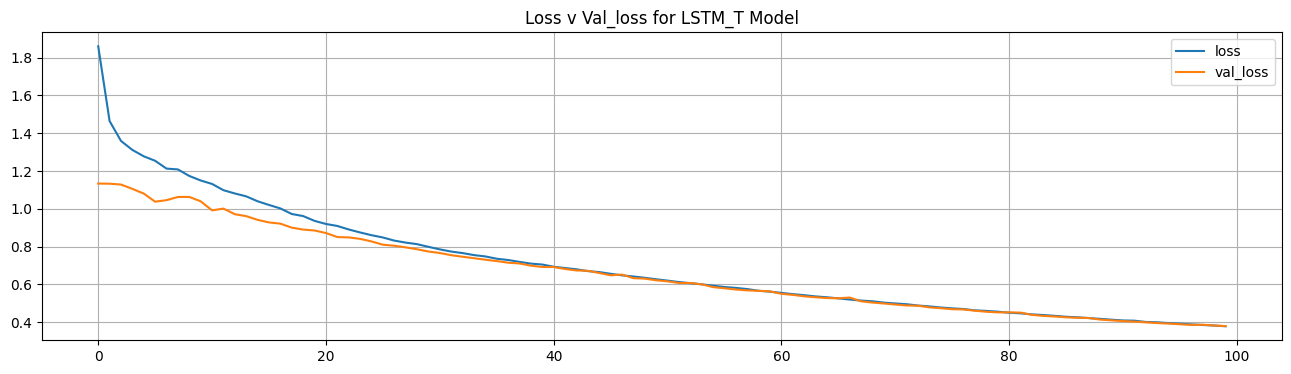

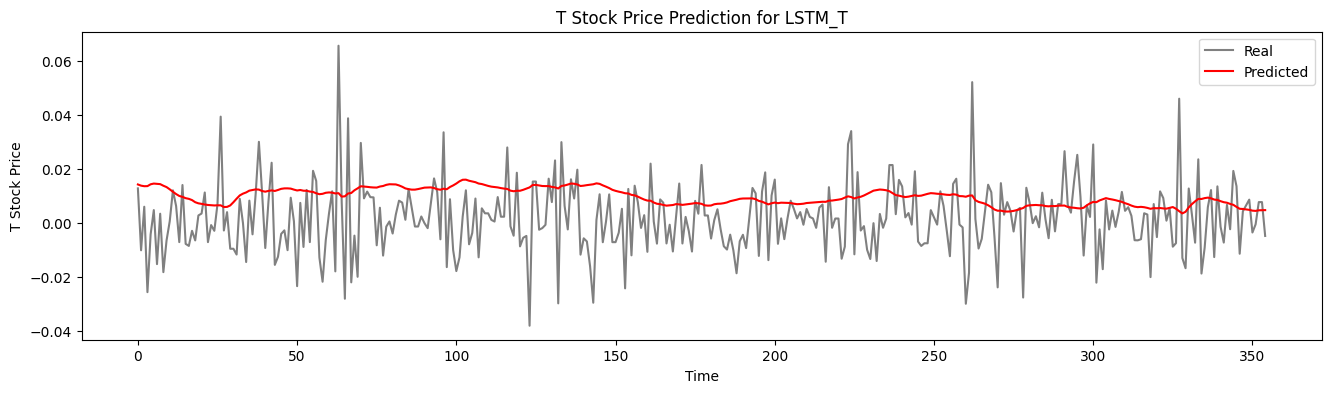

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for T

Processing stock: VZ
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


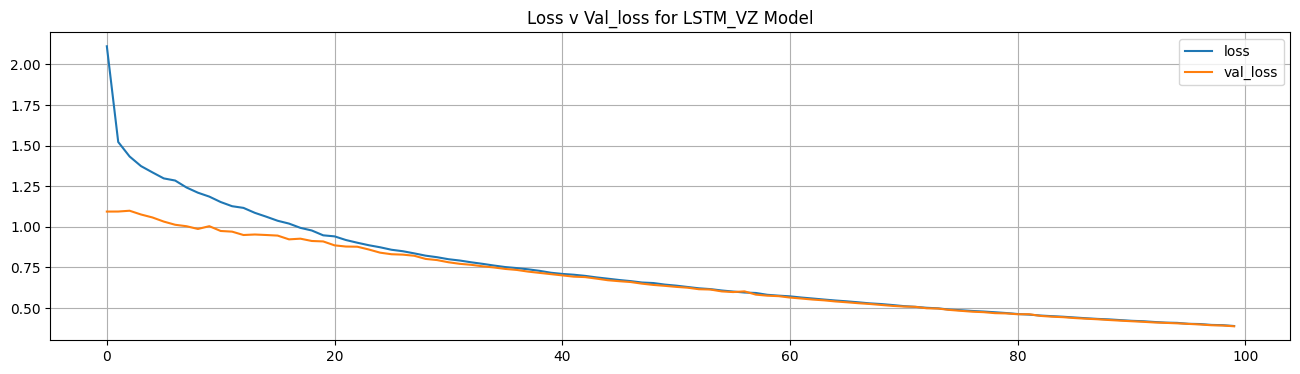

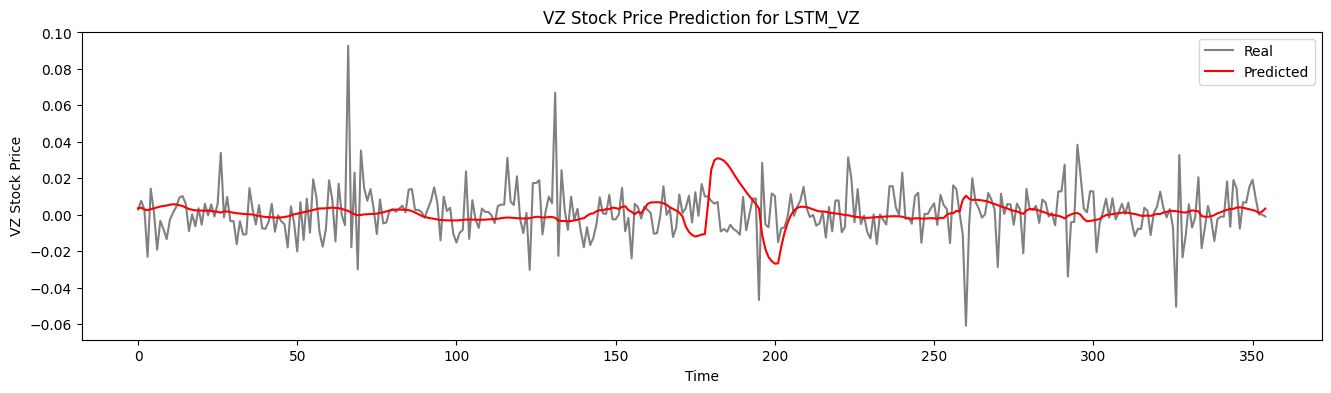

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for VZ

Processing stock: GOOG
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


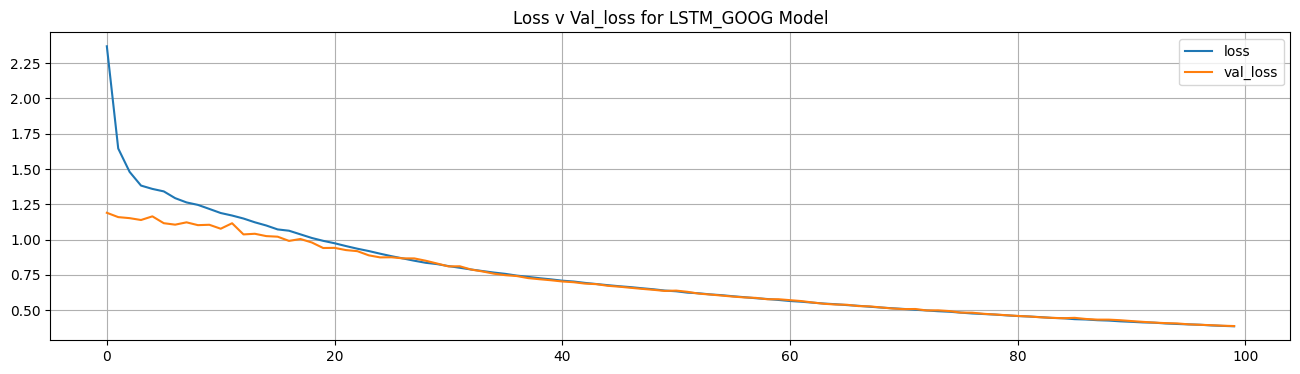

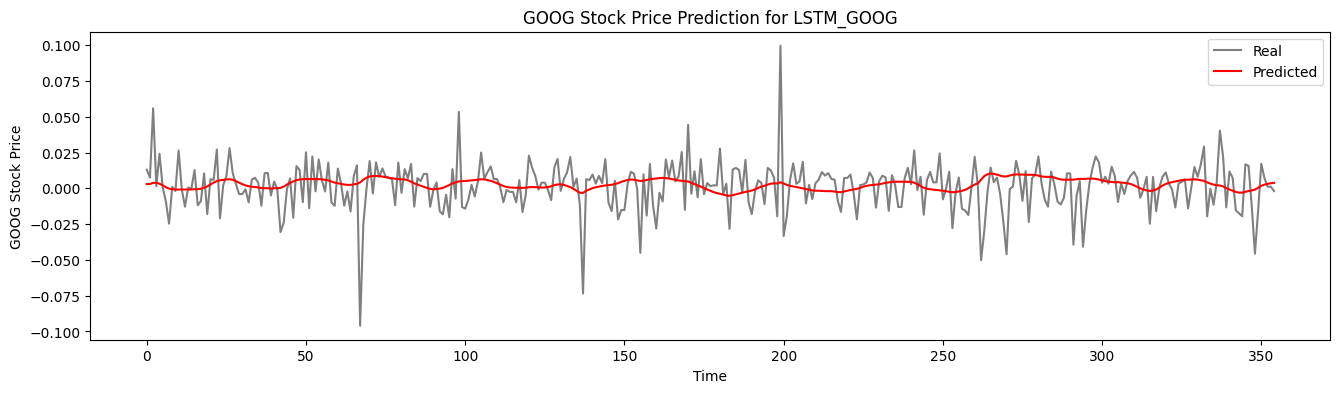

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for GOOG

Processing stock: META
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


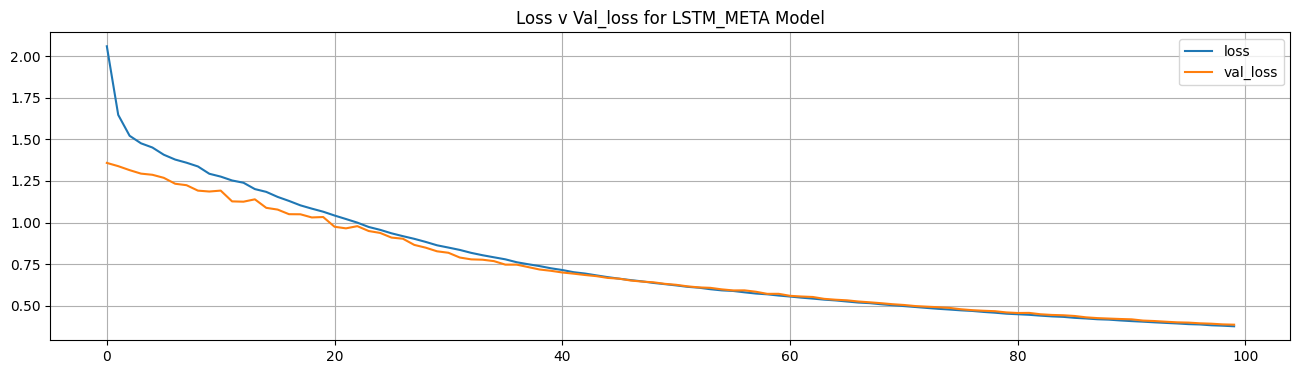

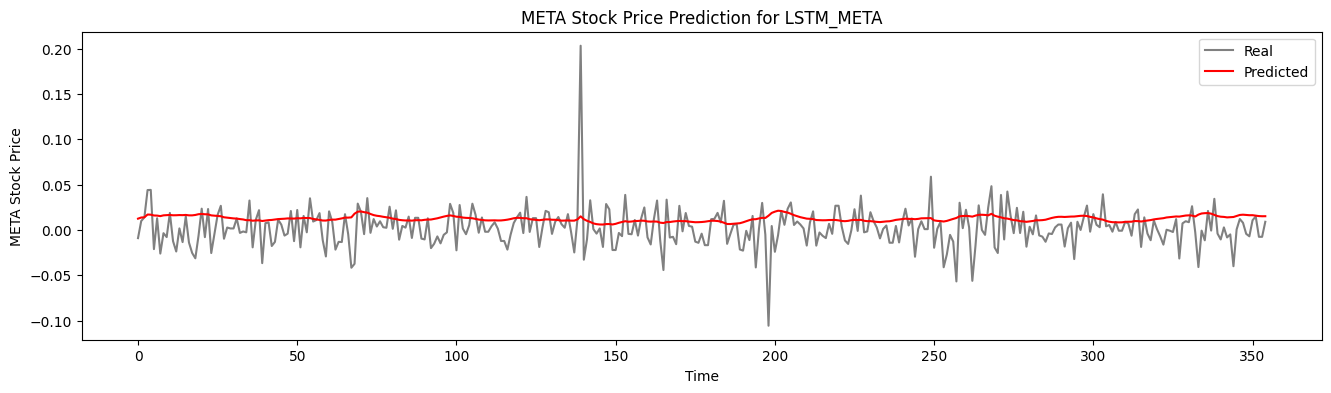

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for META

Processing stock: NFLX
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


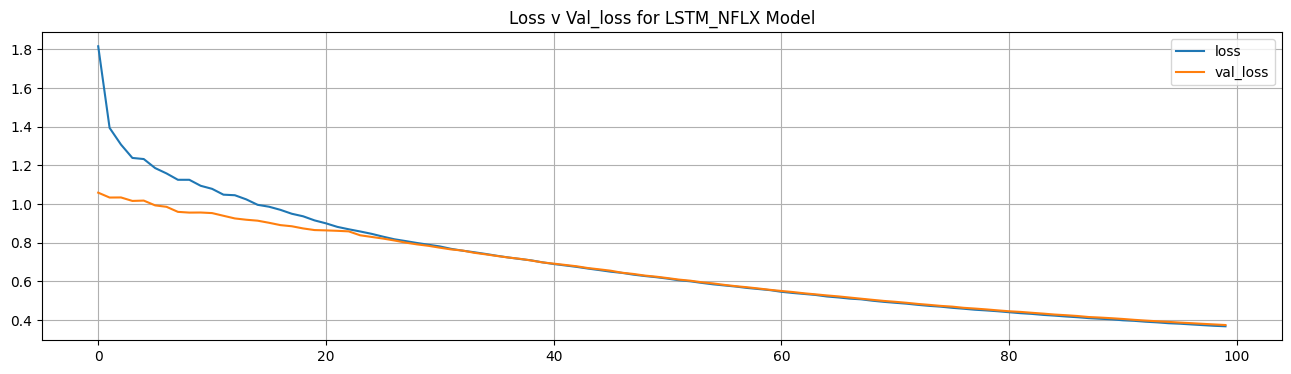

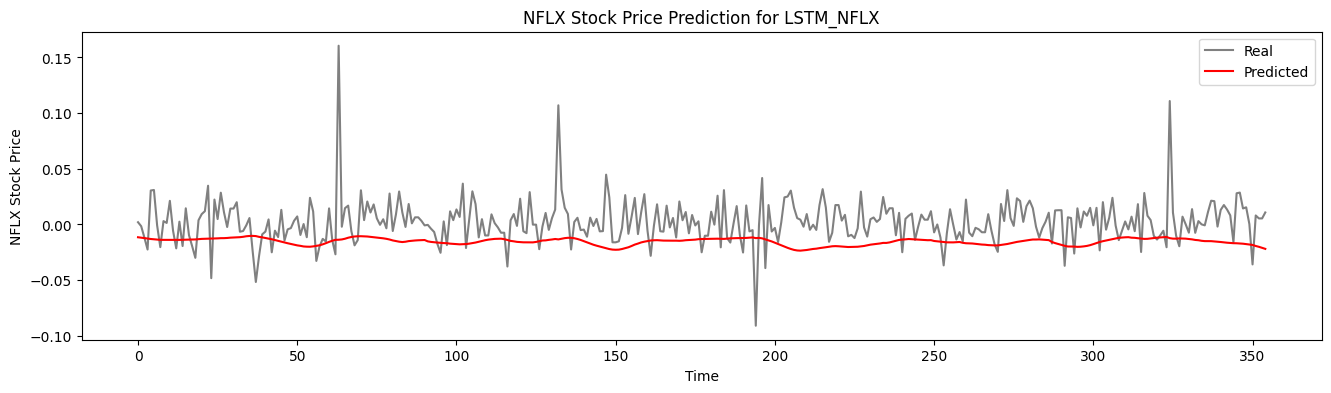

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for NFLX

Processing stock: DIS
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


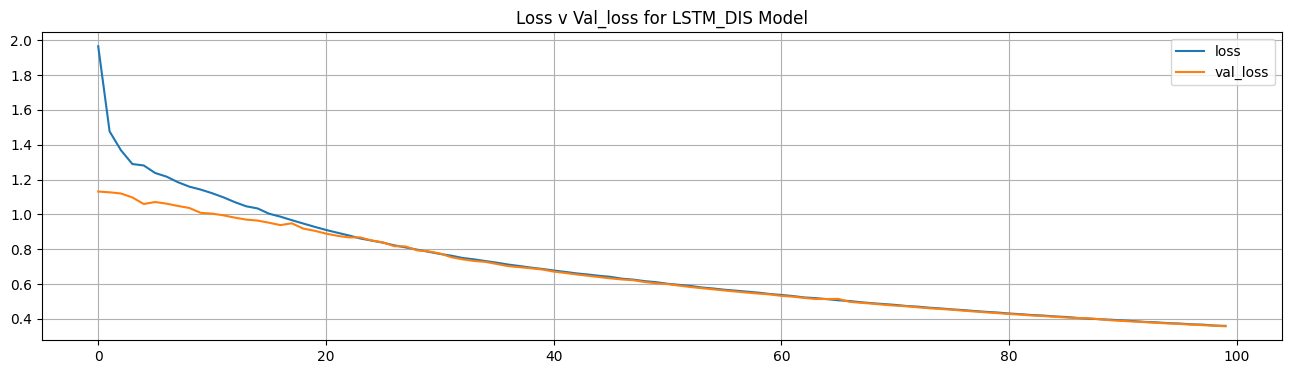

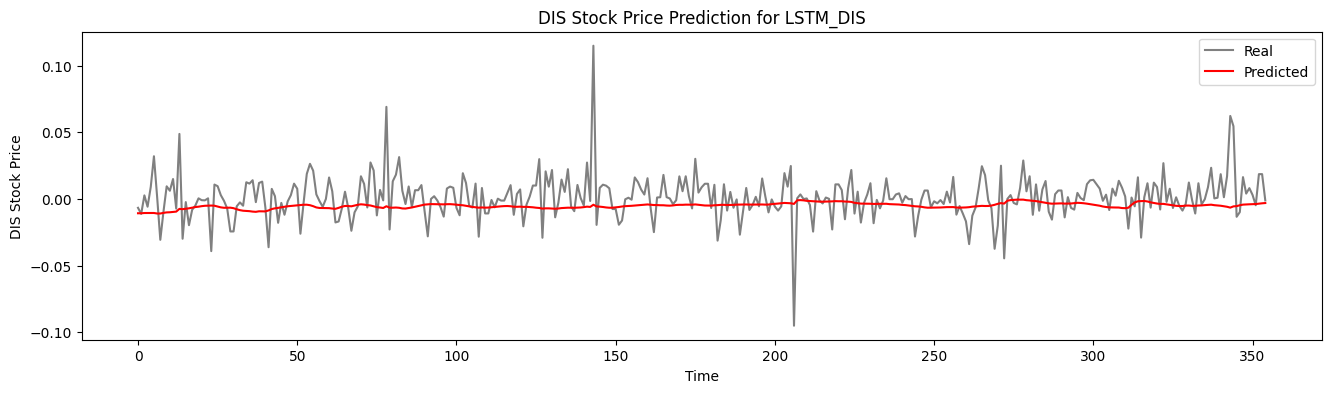

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for DIS

Processing stock: MCD
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


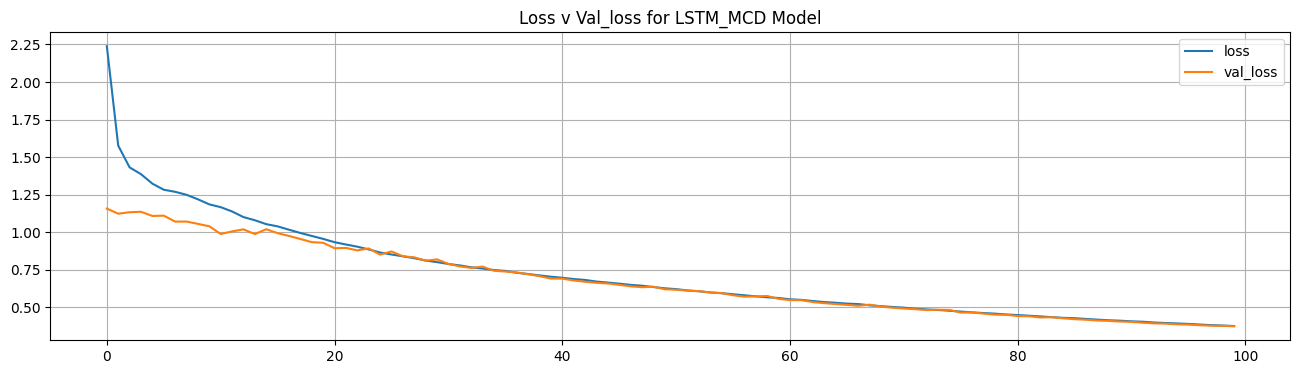

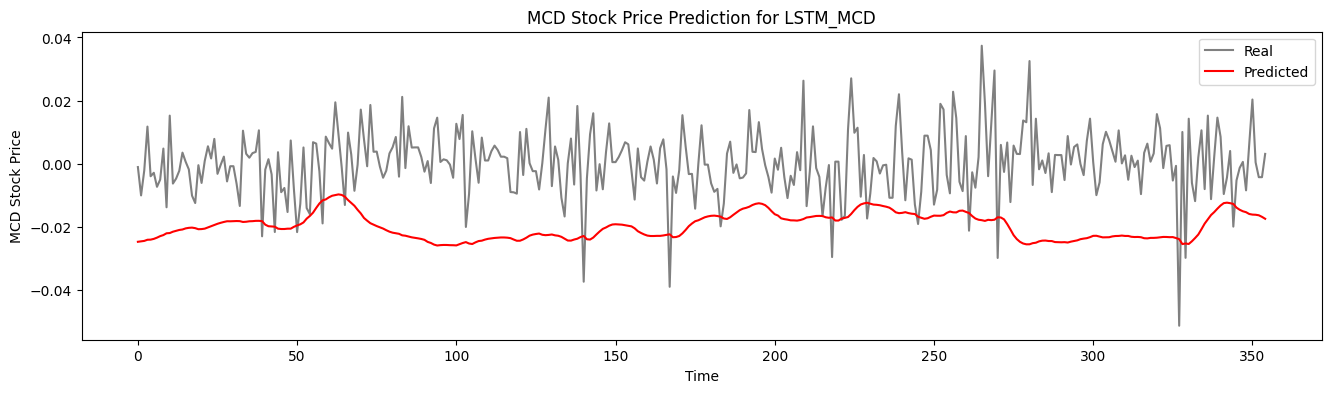

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for MCD

Processing stock: AZO
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


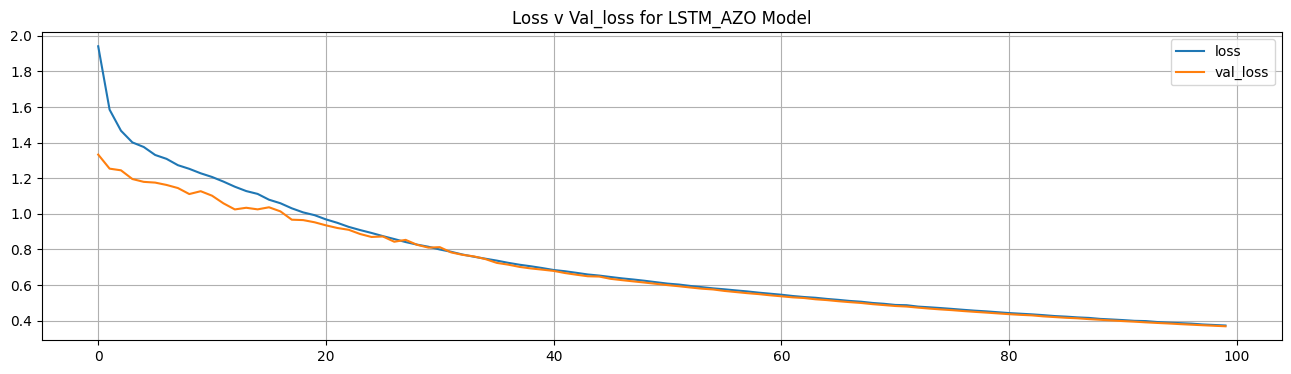

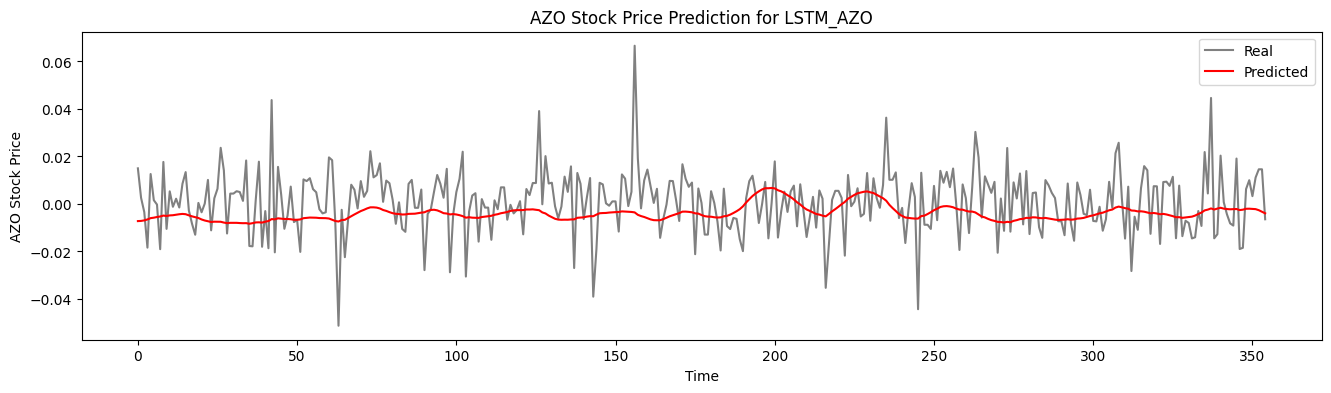

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for AZO

Processing stock: AMZN
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


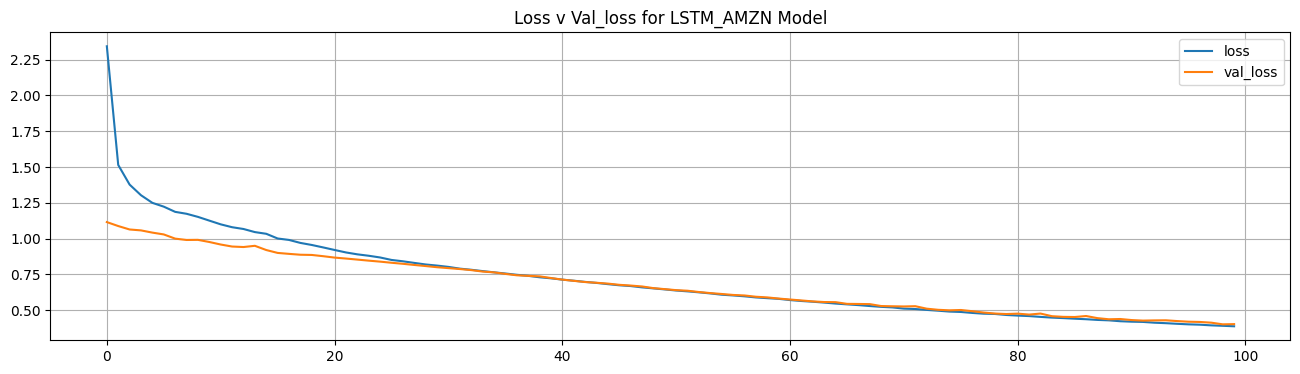

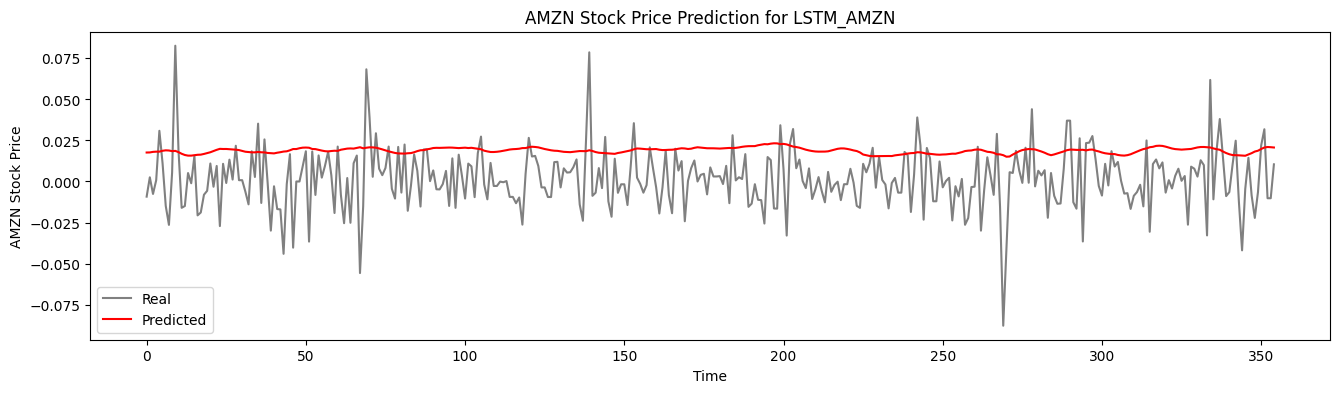

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for AMZN

Processing stock: HD
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


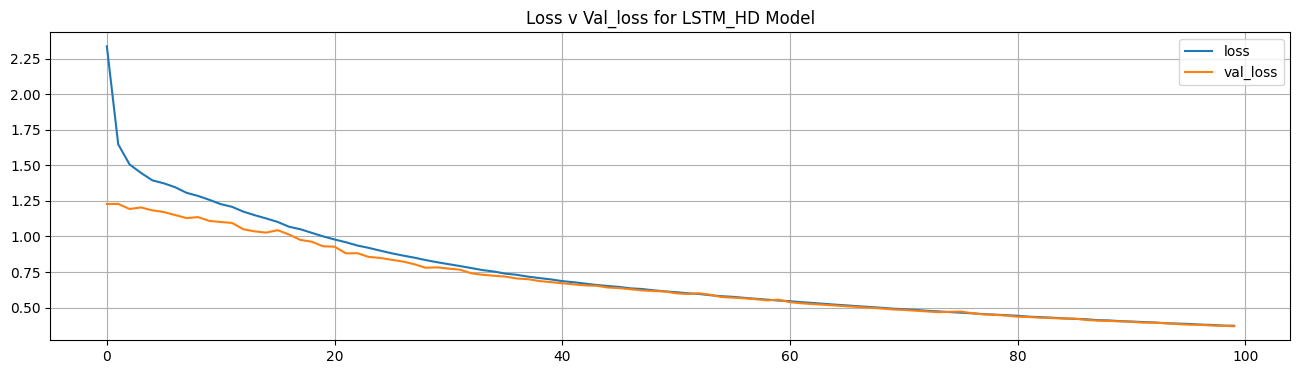

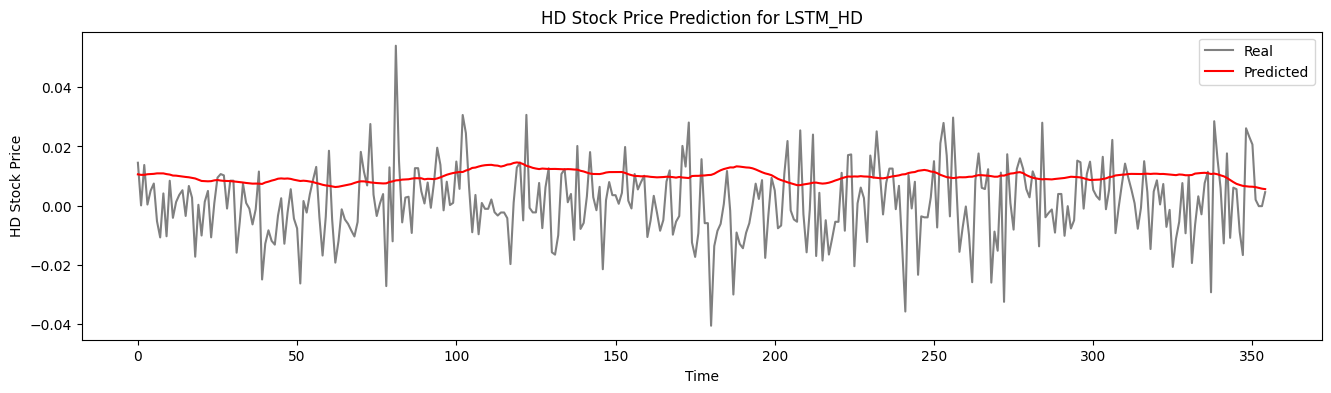

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for HD

Processing stock: TSLA
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


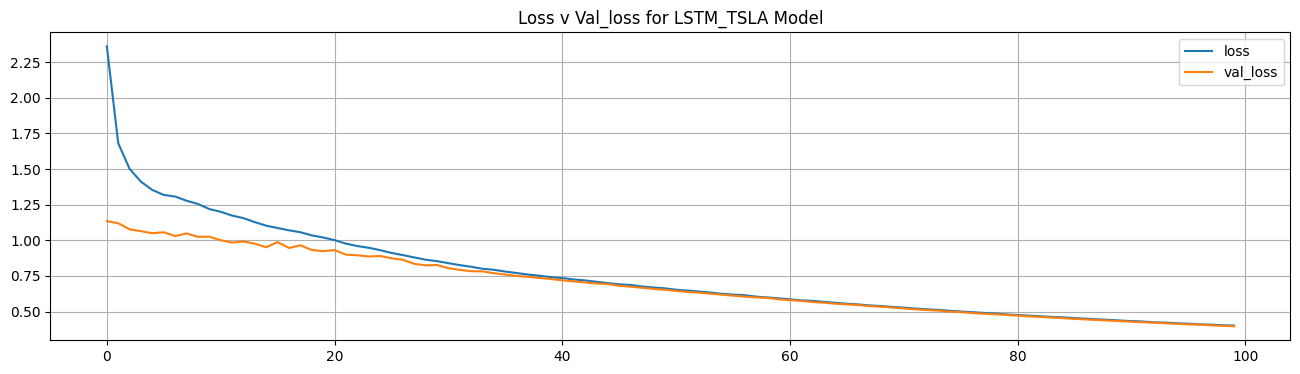

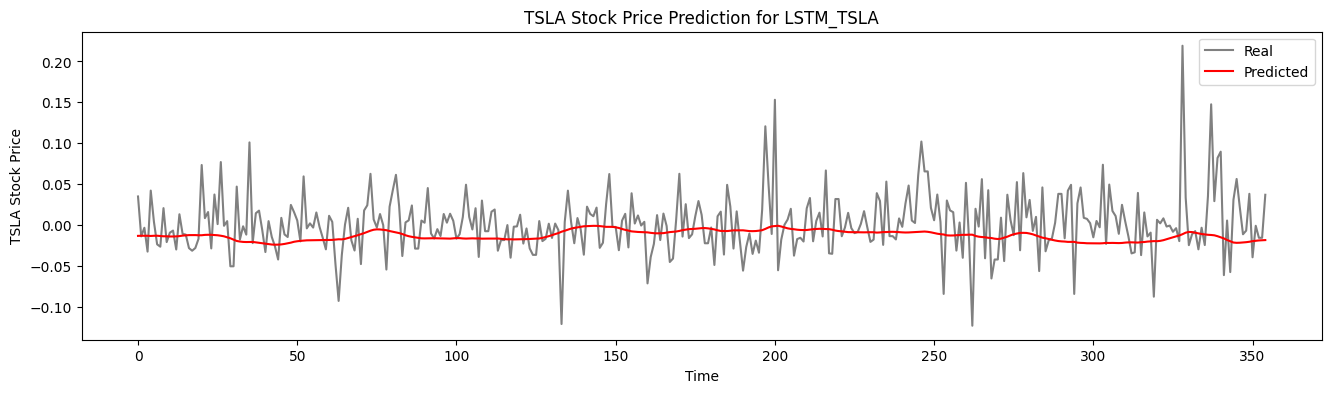

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for TSLA

Processing stock: BKNG
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


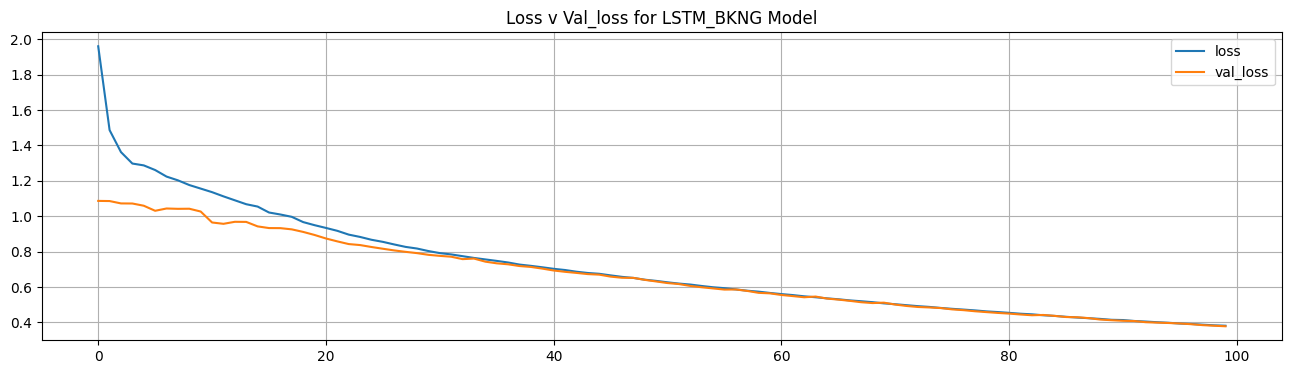

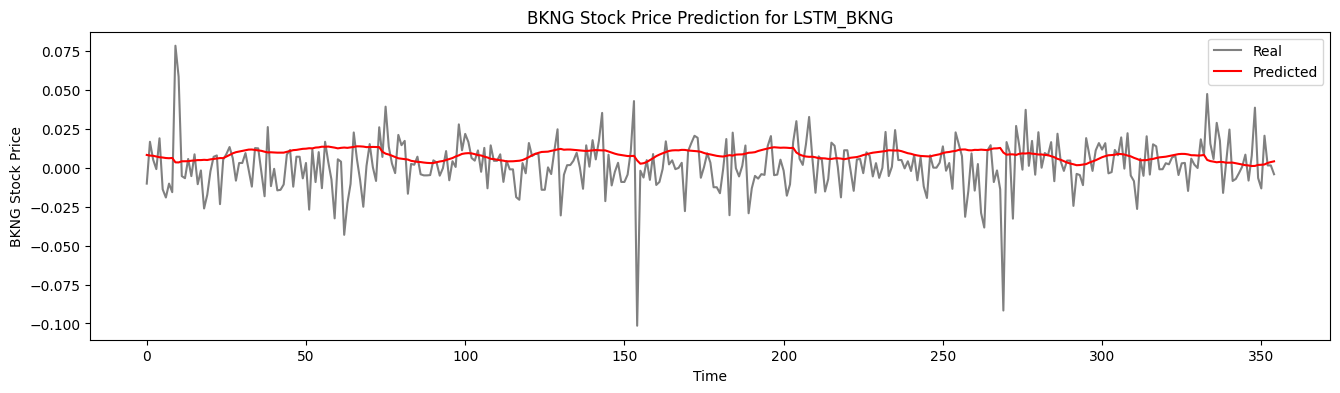

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for BKNG

Processing stock: CTRA
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


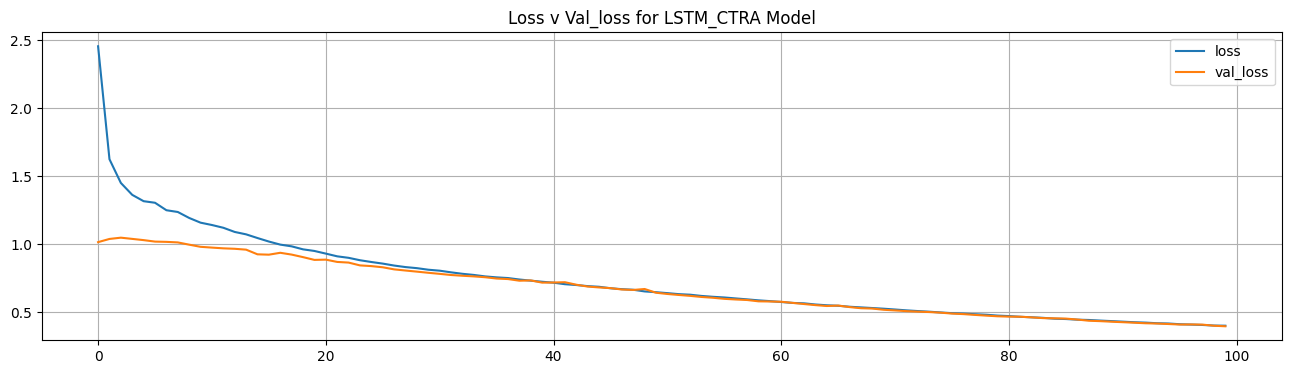

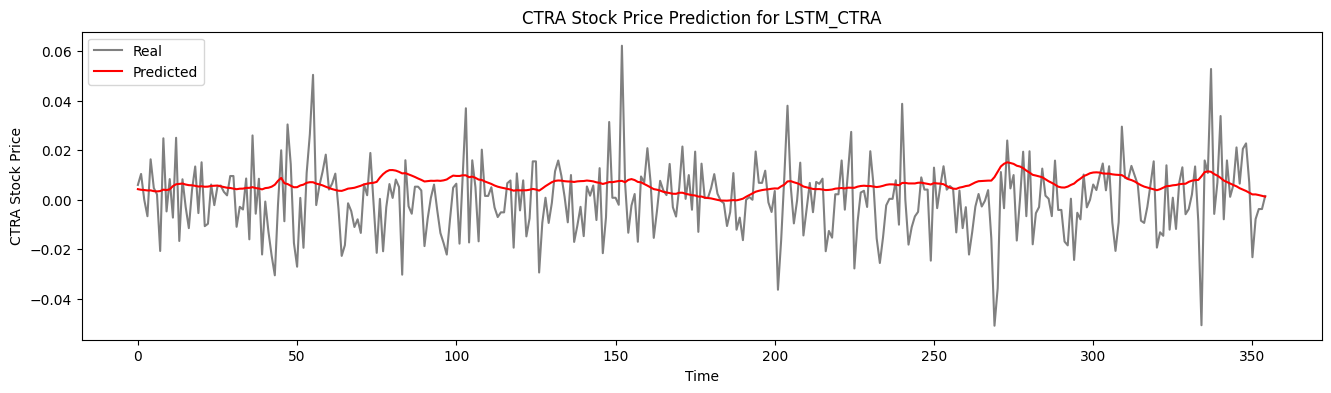

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for CTRA

Processing stock: XOM
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


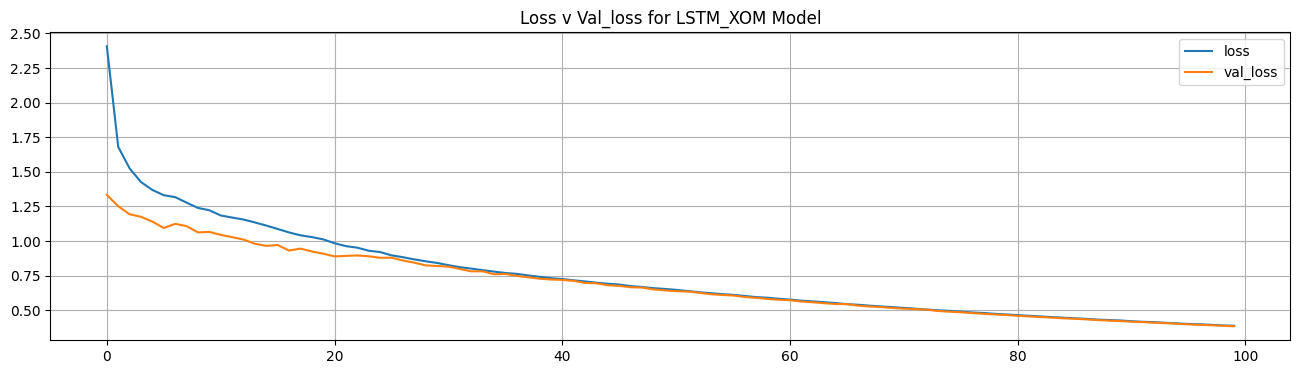

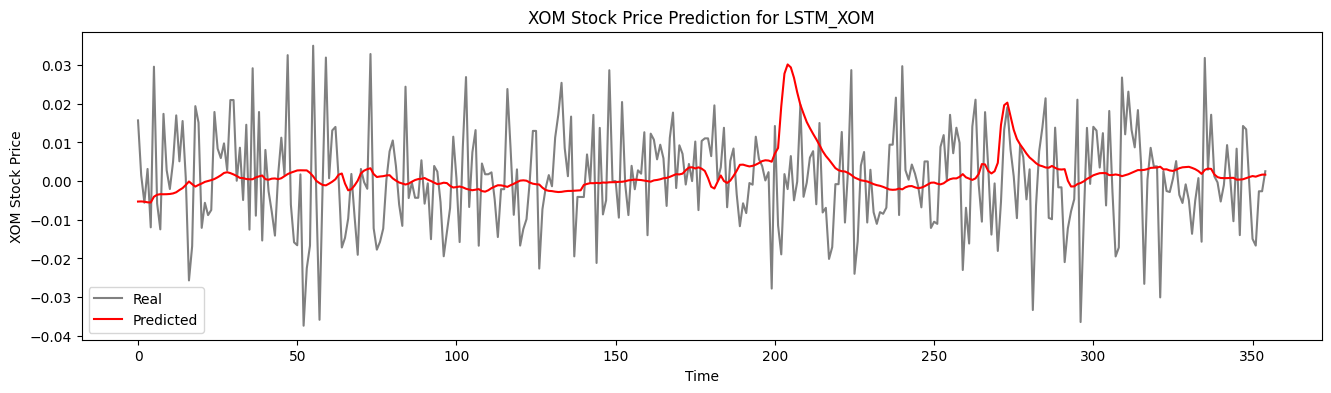

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for XOM

Processing stock: CVX
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


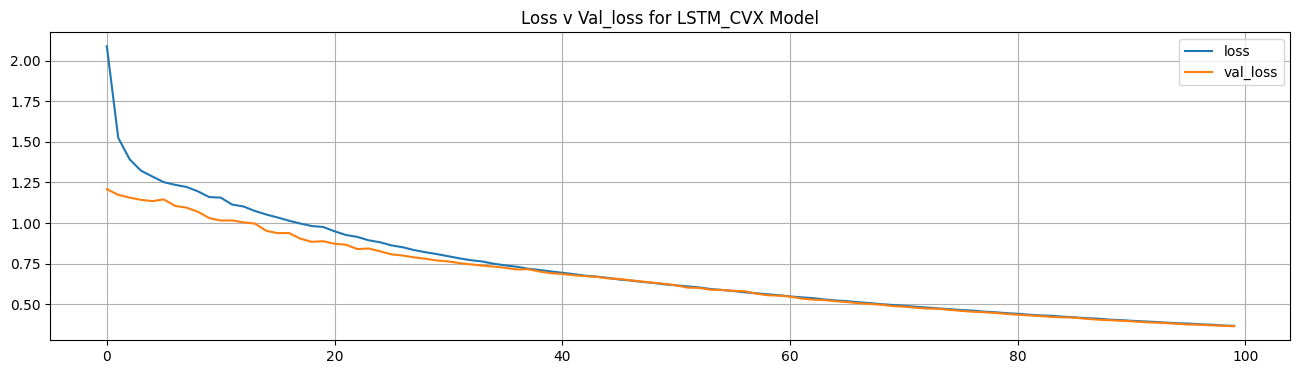

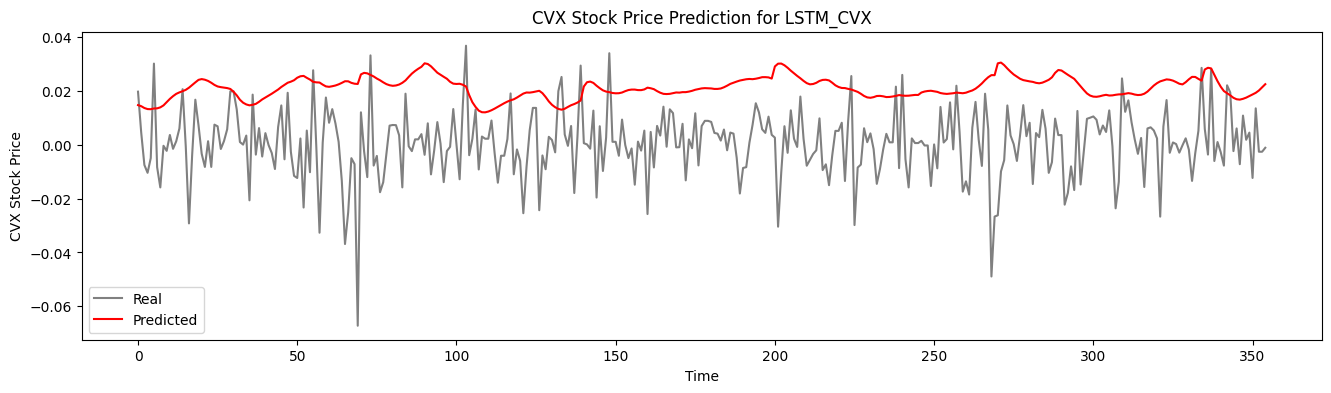

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for CVX

Processing stock: EOG
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


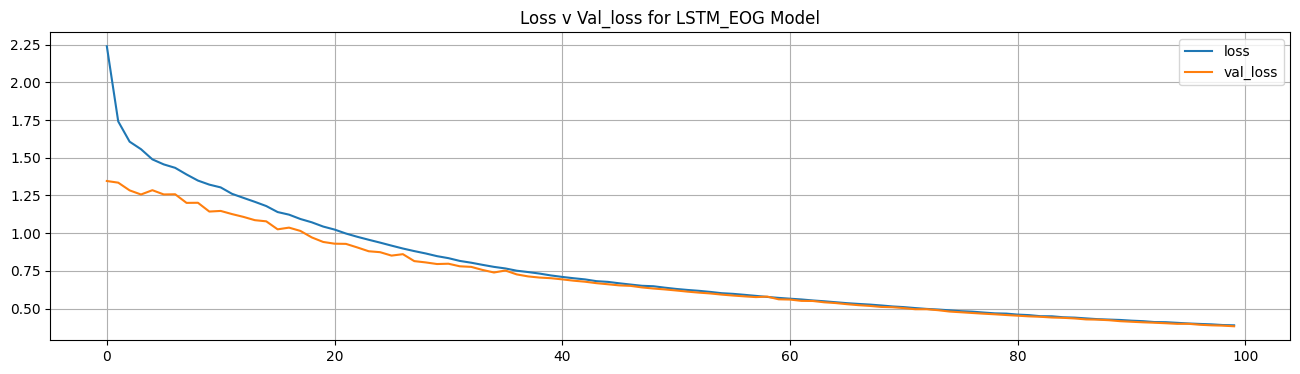

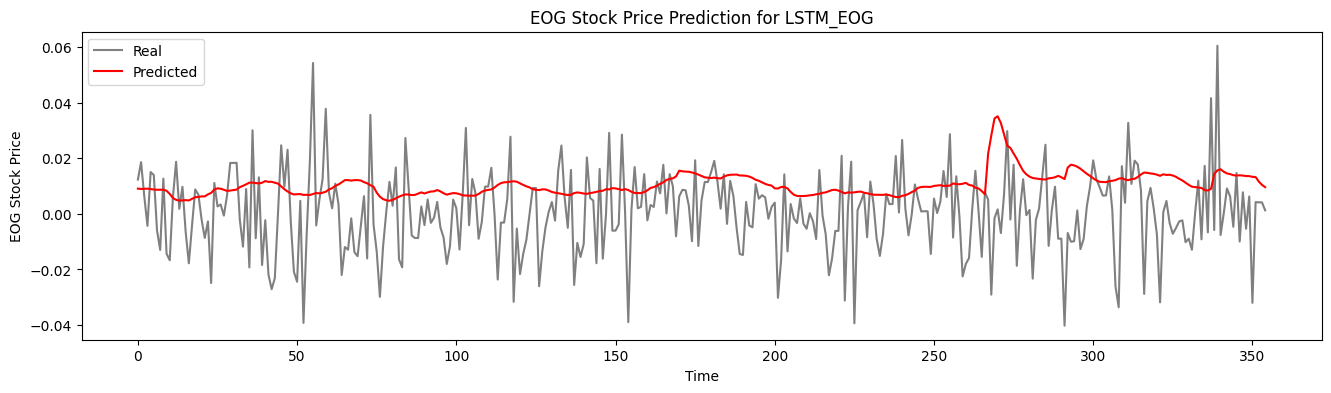

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for EOG

Processing stock: OKE
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


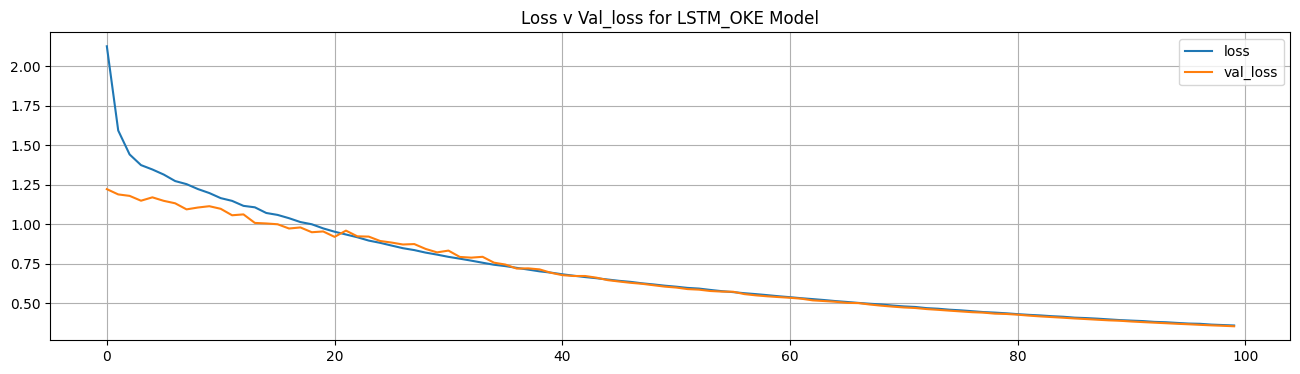

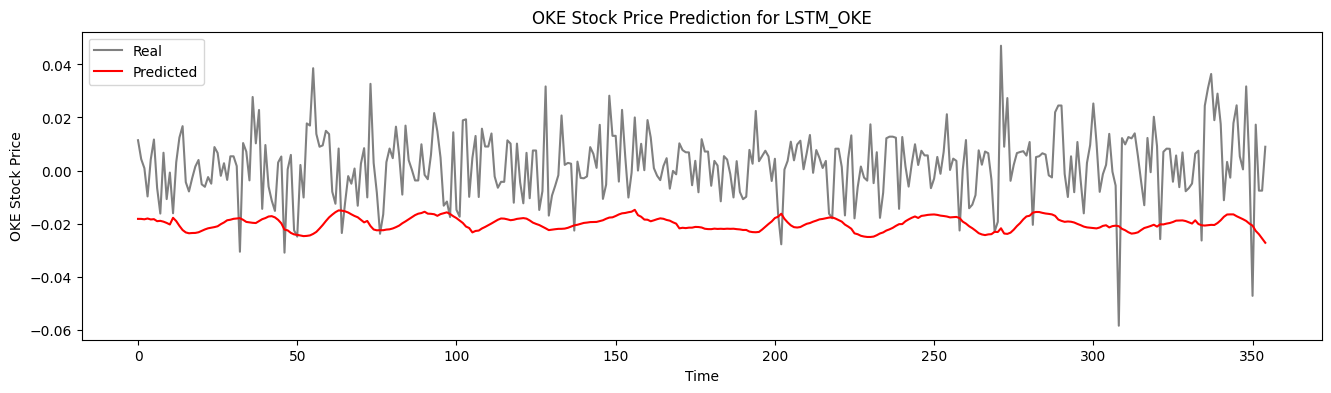

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for OKE

Processing stock: COP
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


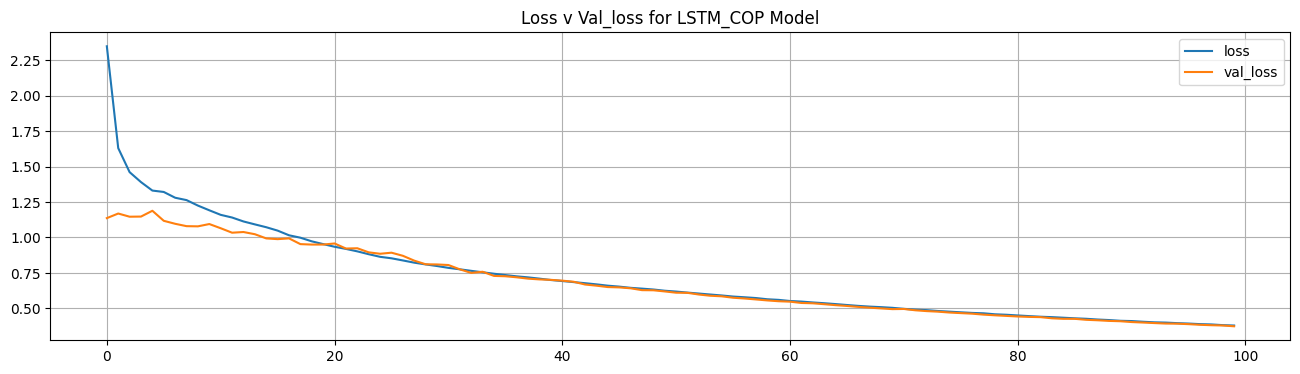

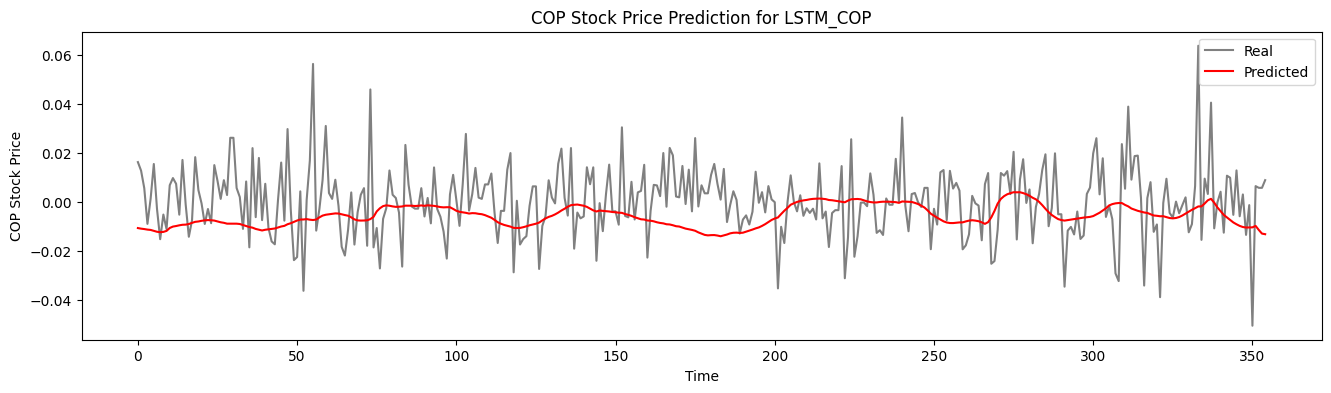

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for COP

Processing stock: PGR
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


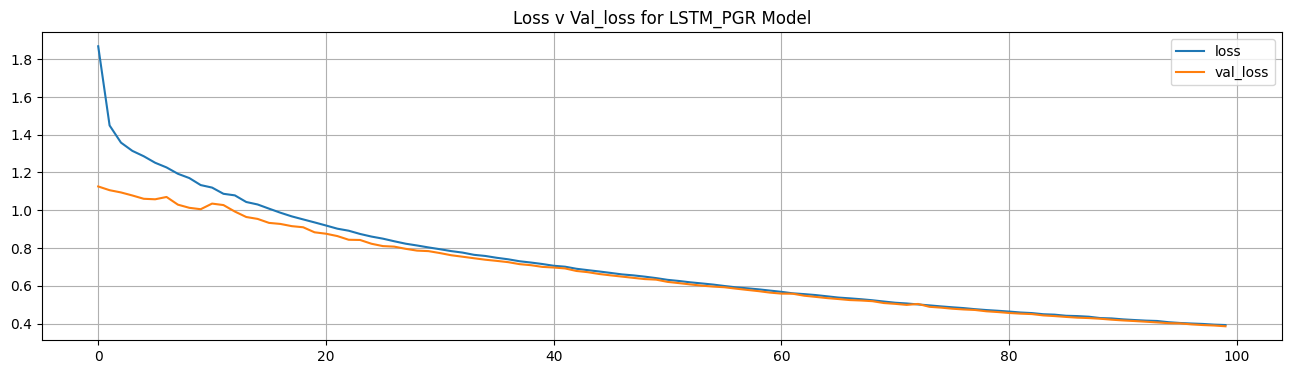

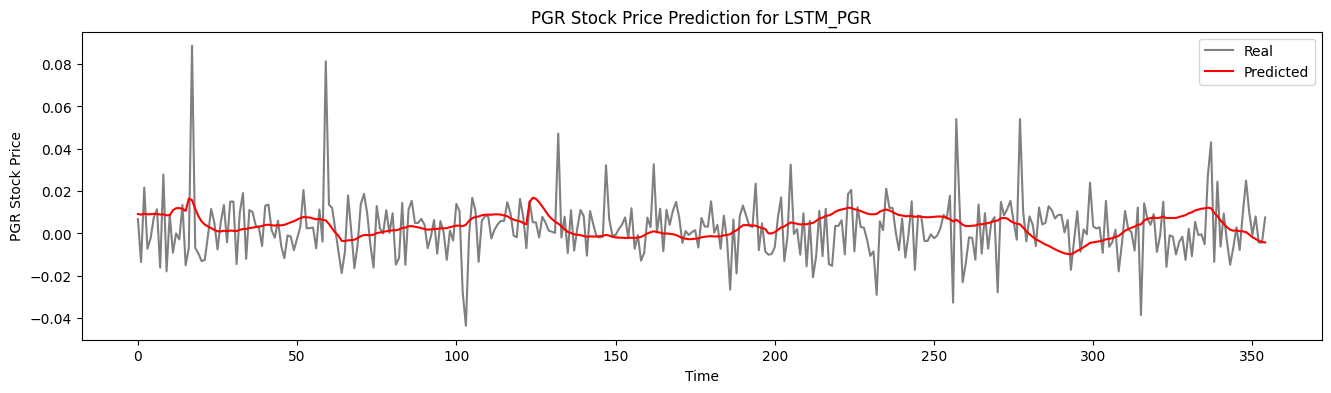

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for PGR

Processing stock: CB
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


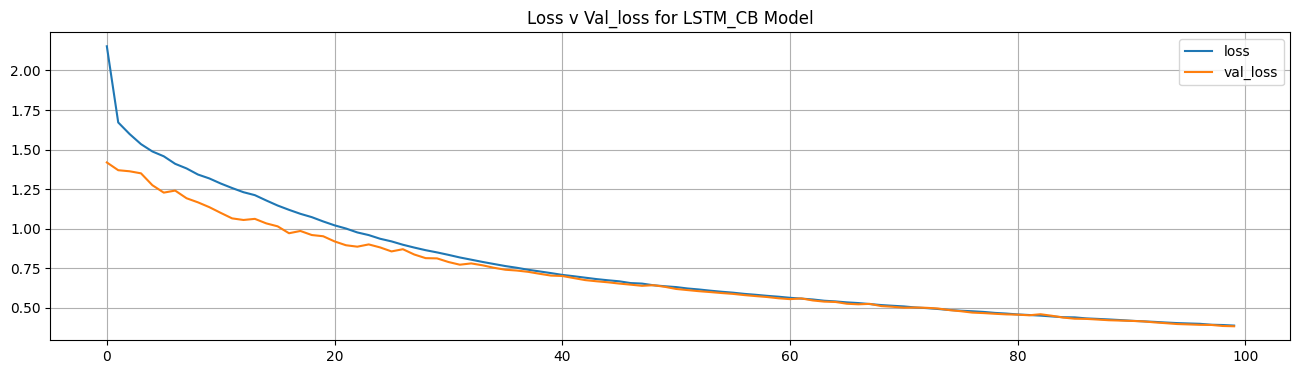

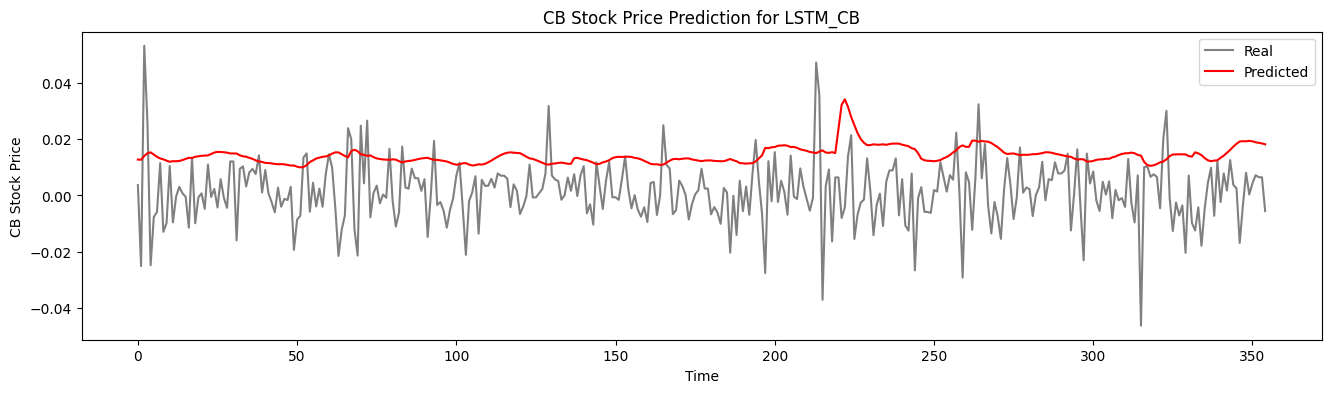

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for CB

Processing stock: BRK-B
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


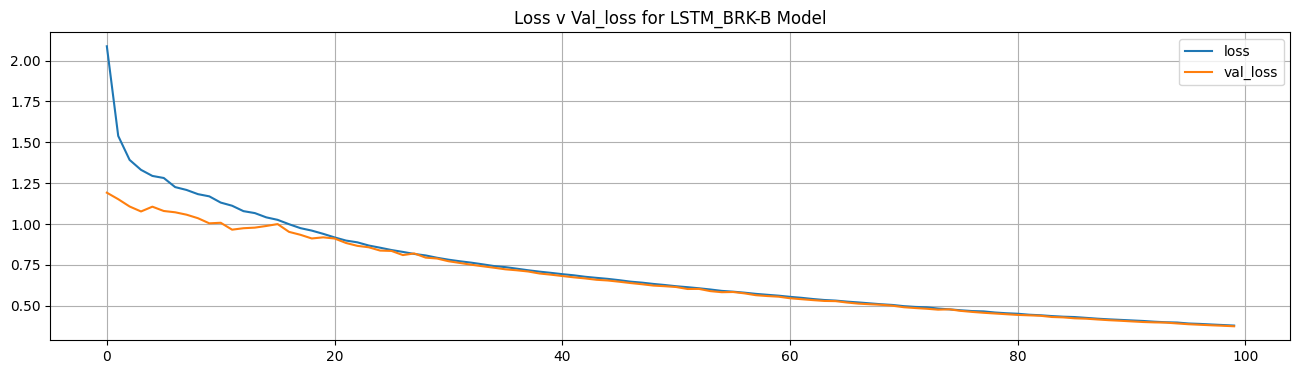

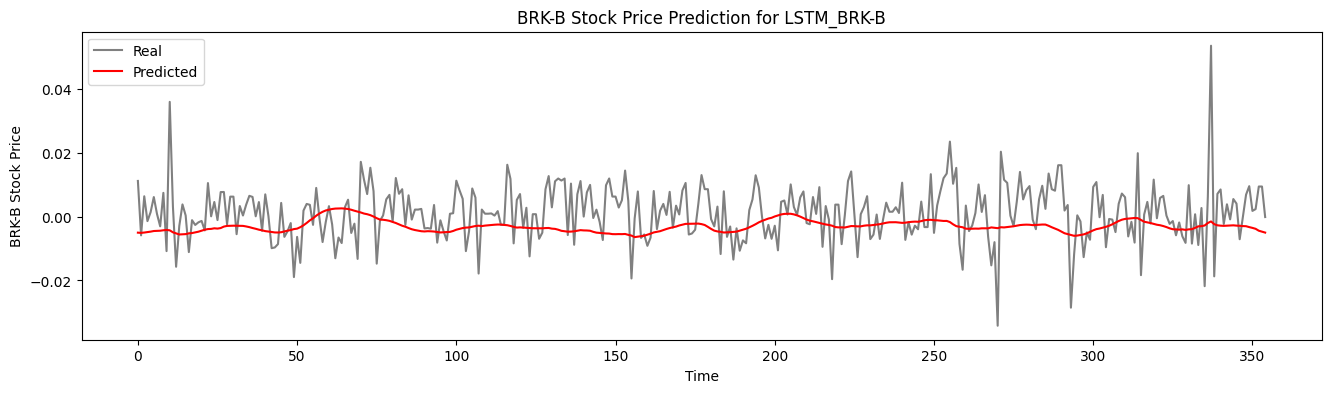

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for BRK-B

Processing stock: JPM
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


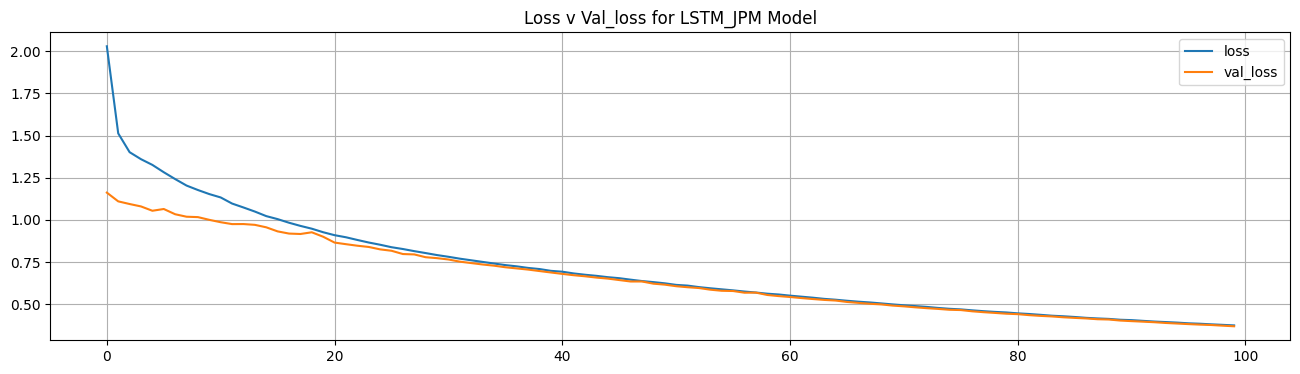

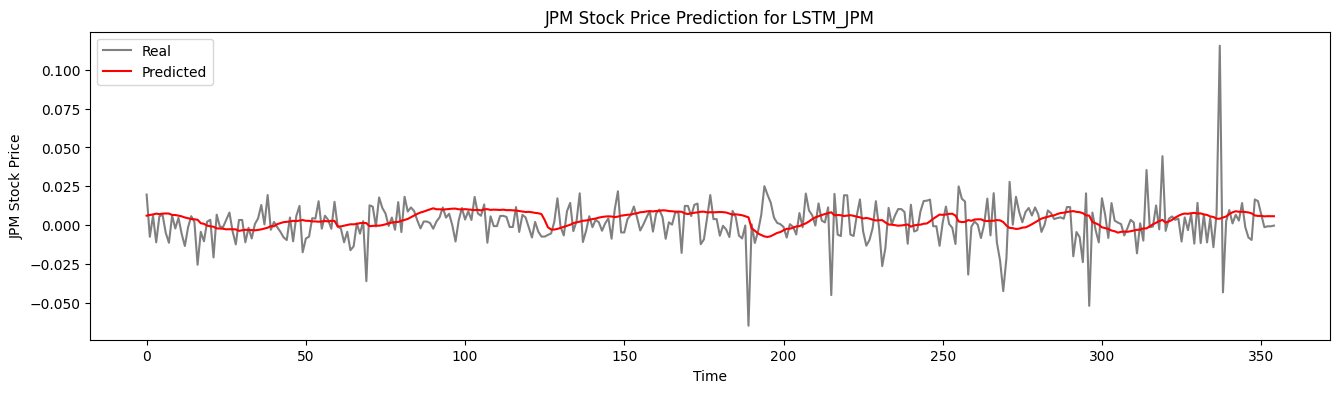

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for JPM

Processing stock: BAC
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


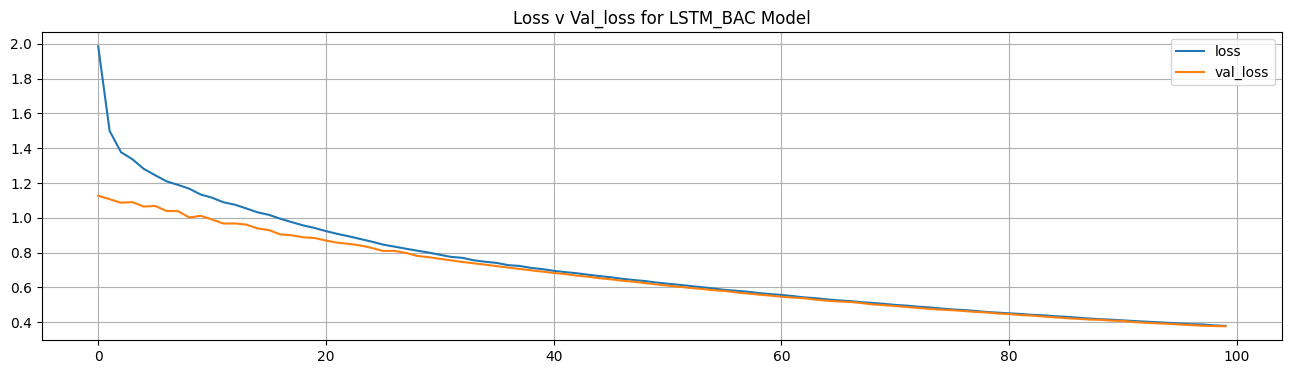

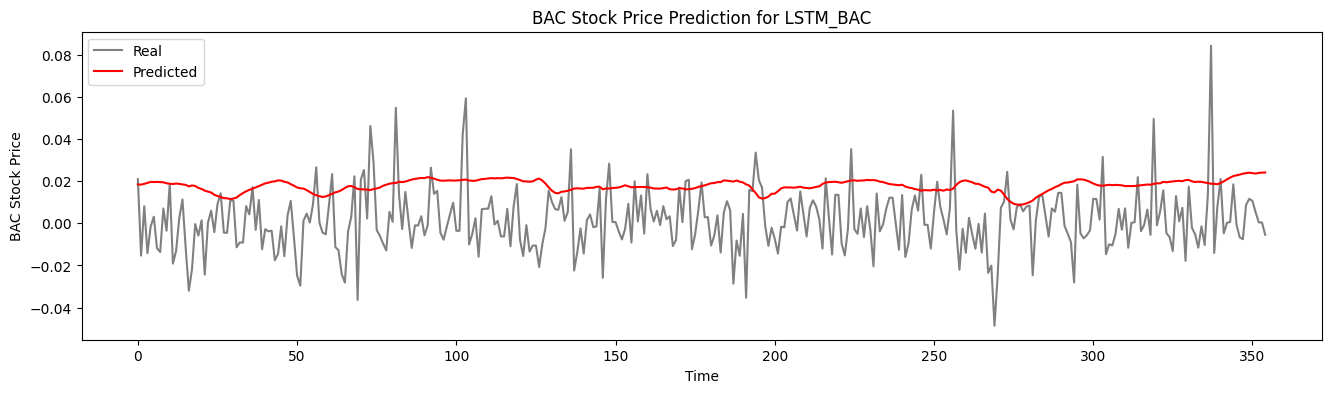

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for BAC

Processing stock: GS
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


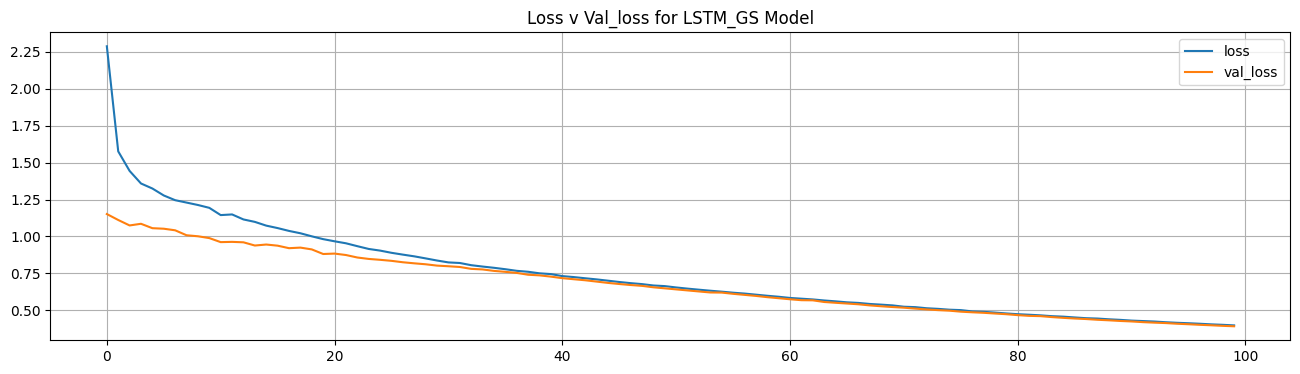

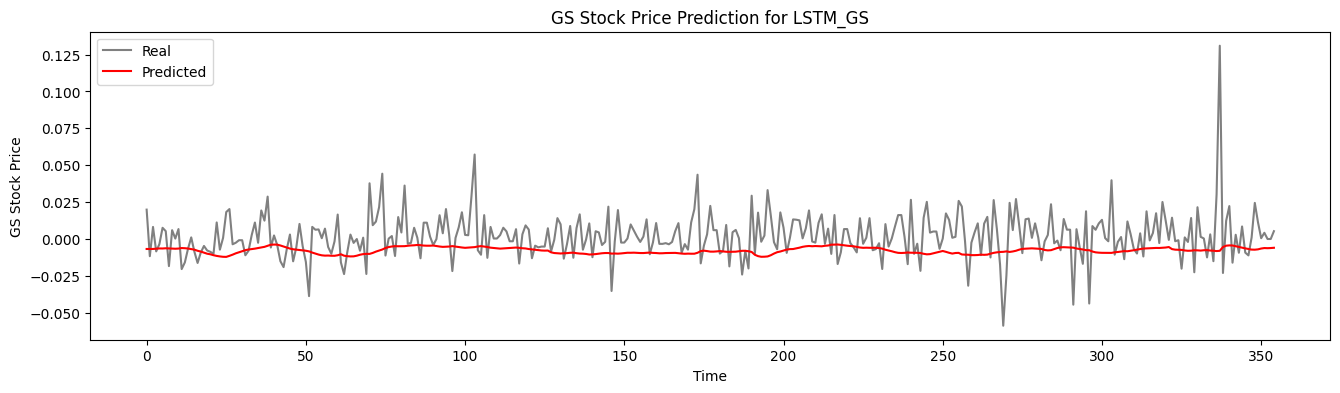

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for GS

Processing stock: LLY
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


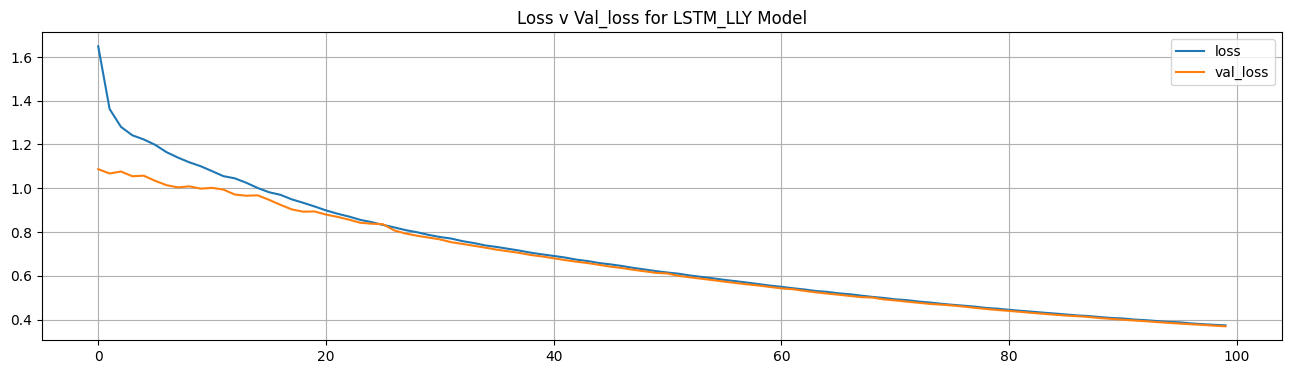

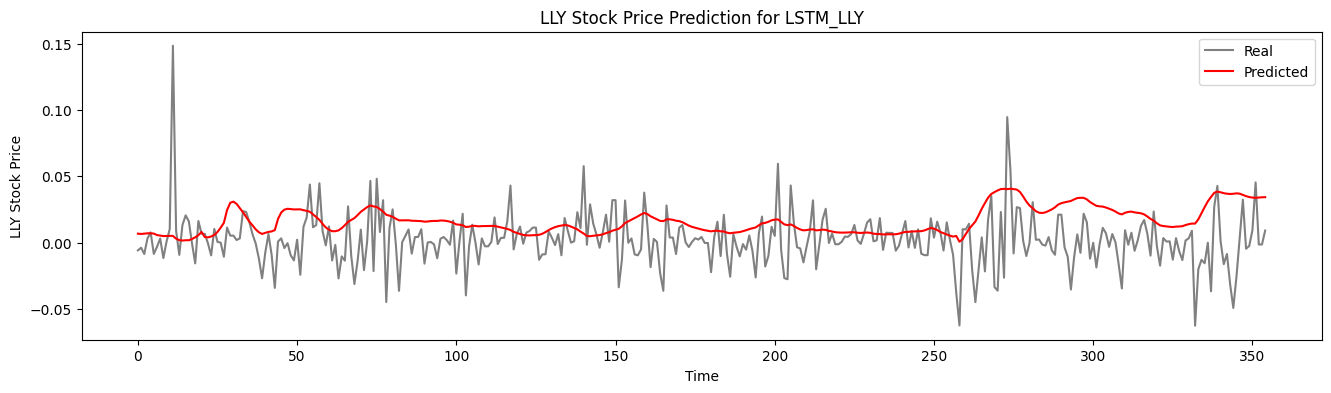

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for LLY

Processing stock: UNH
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


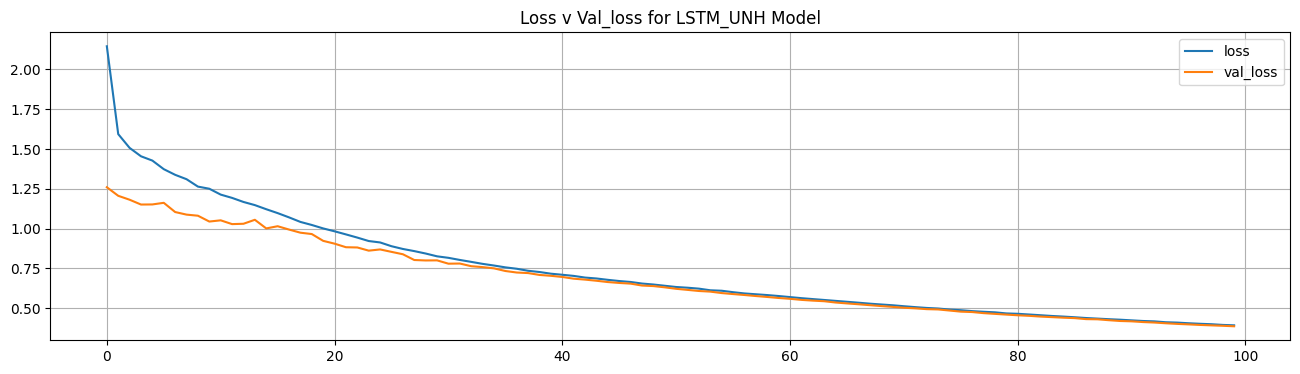

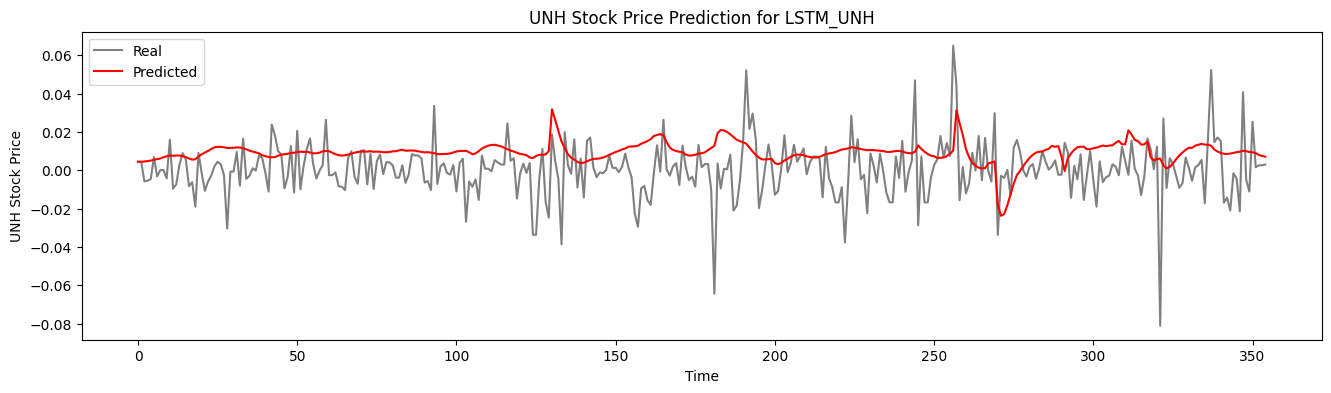

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for UNH

Processing stock: BSX
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


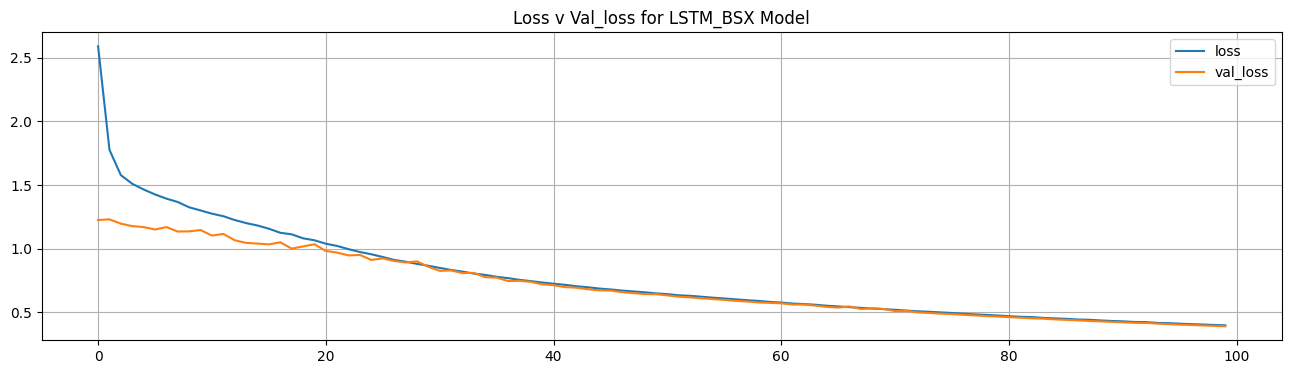

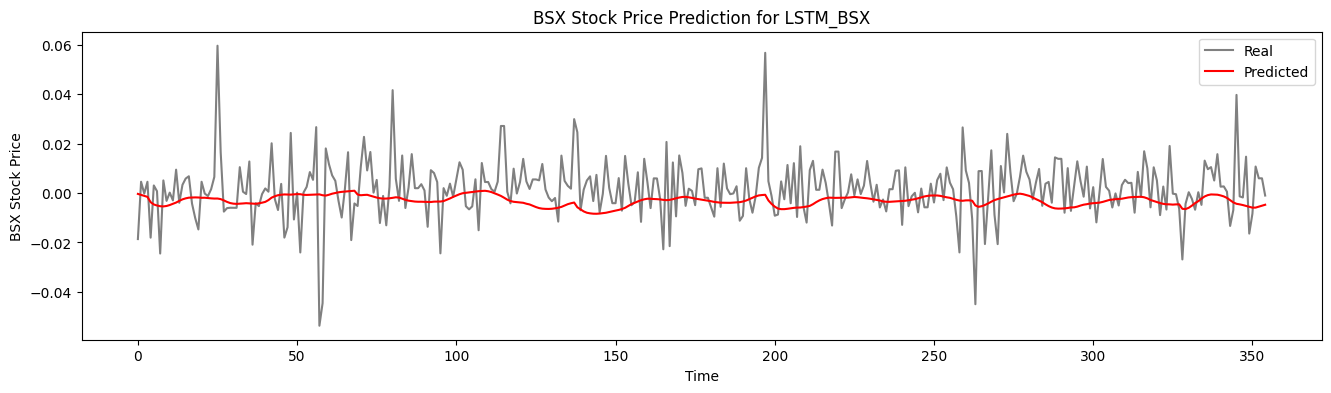

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for BSX

Processing stock: SYK
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


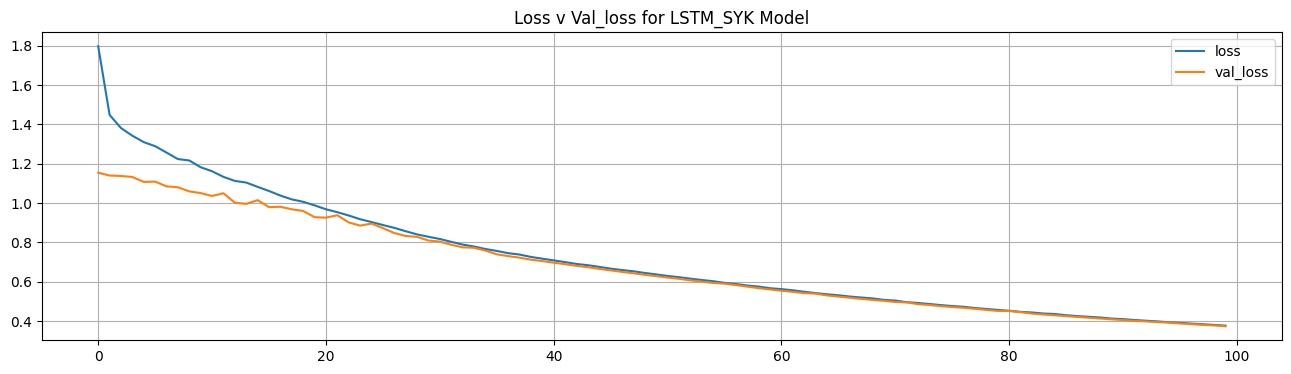

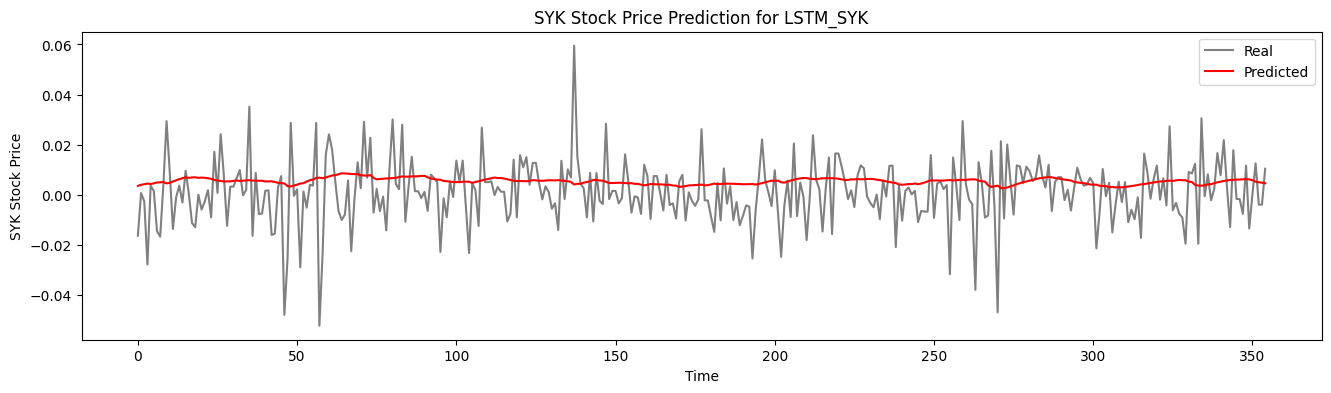

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for SYK

Processing stock: ISRG
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


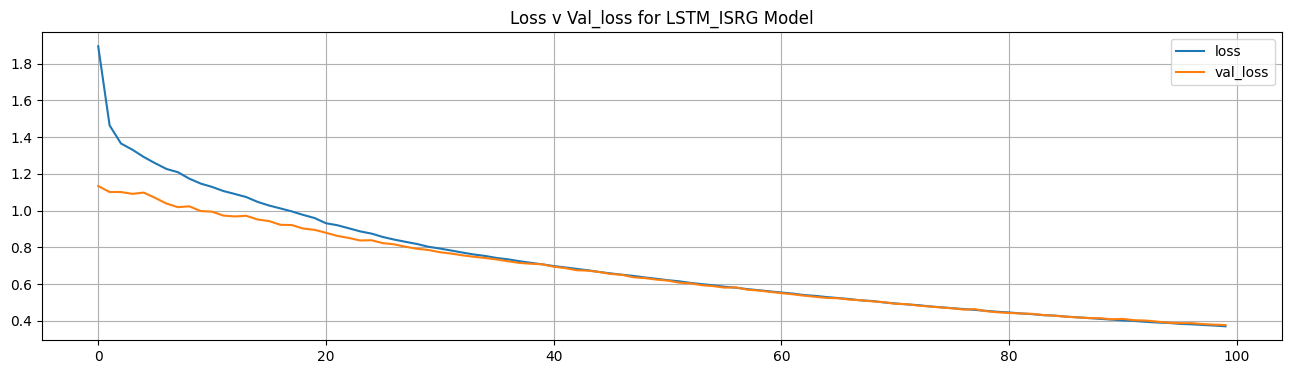

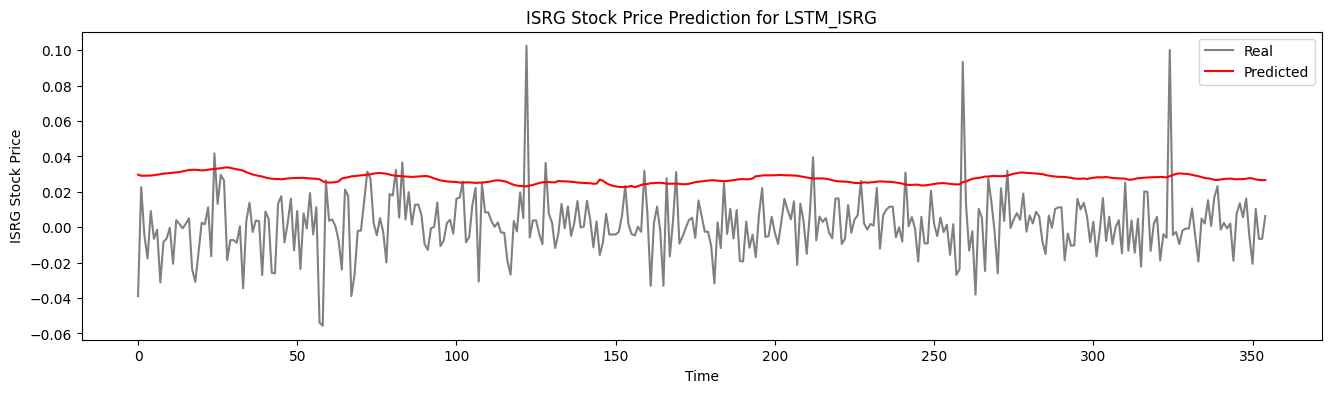

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for ISRG

Processing stock: HCA
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


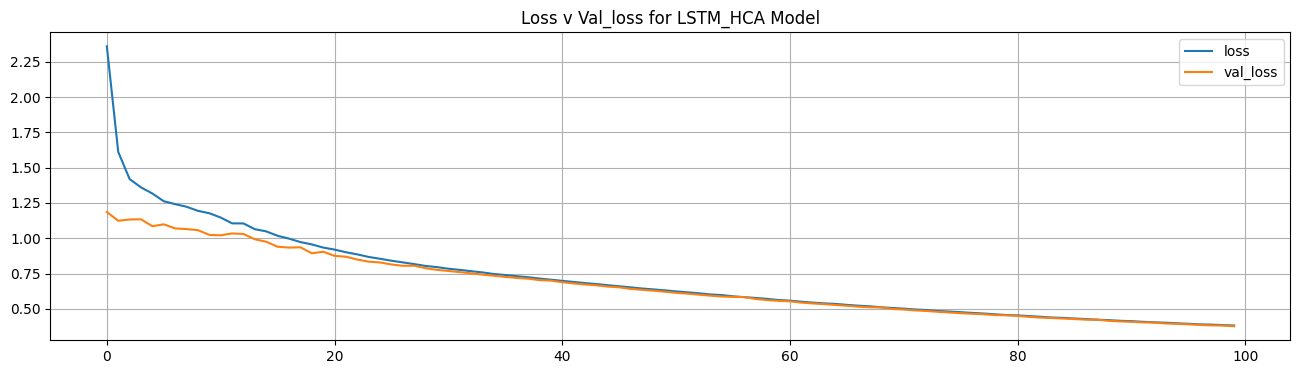

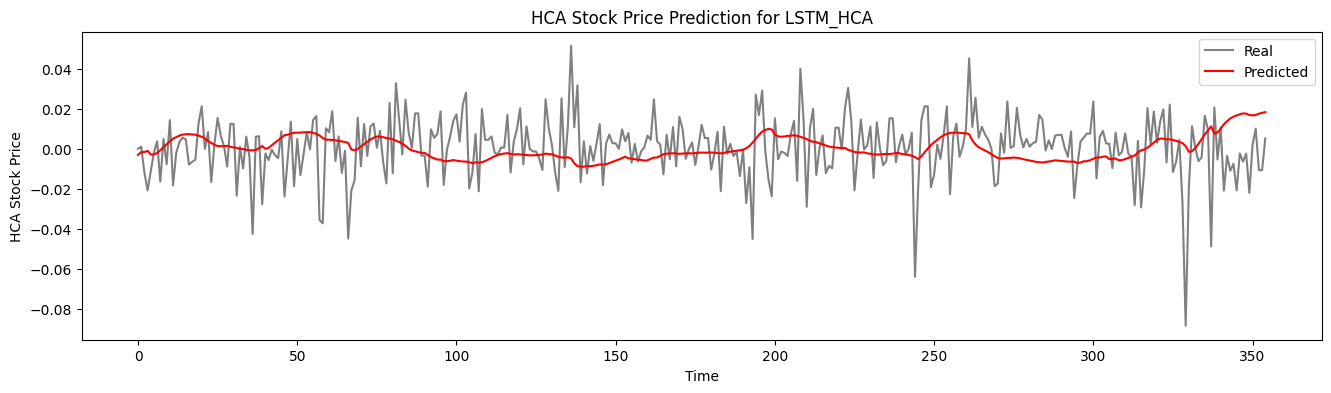

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for HCA

Processing stock: IBM
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


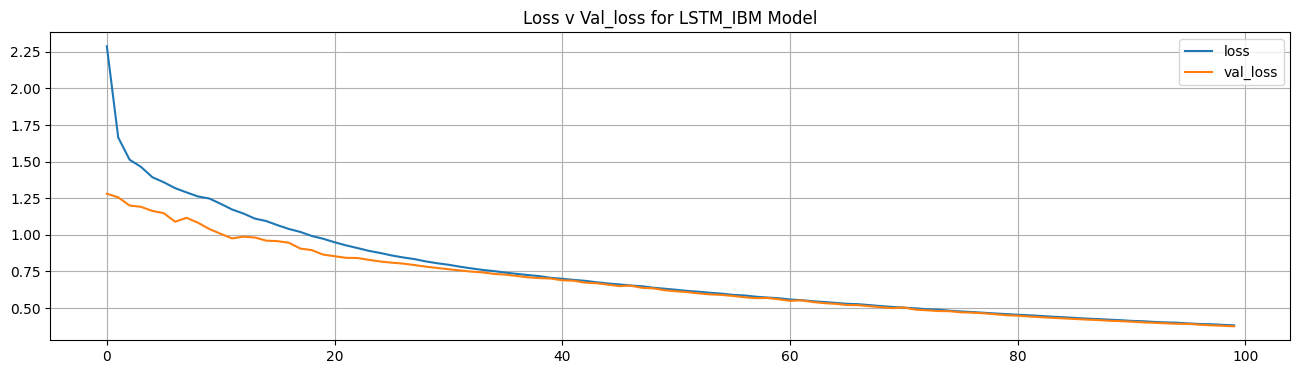

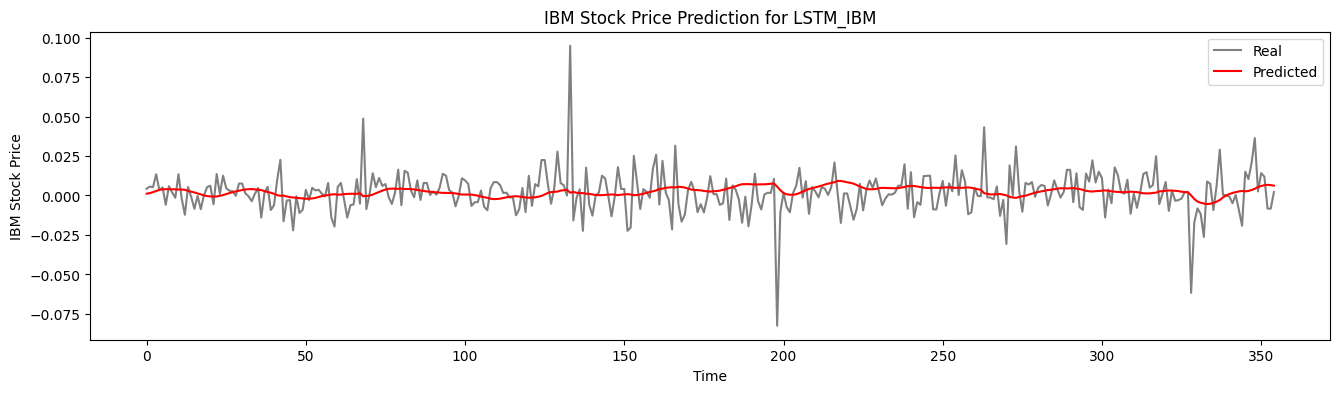

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for IBM

Processing stock: TYL
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


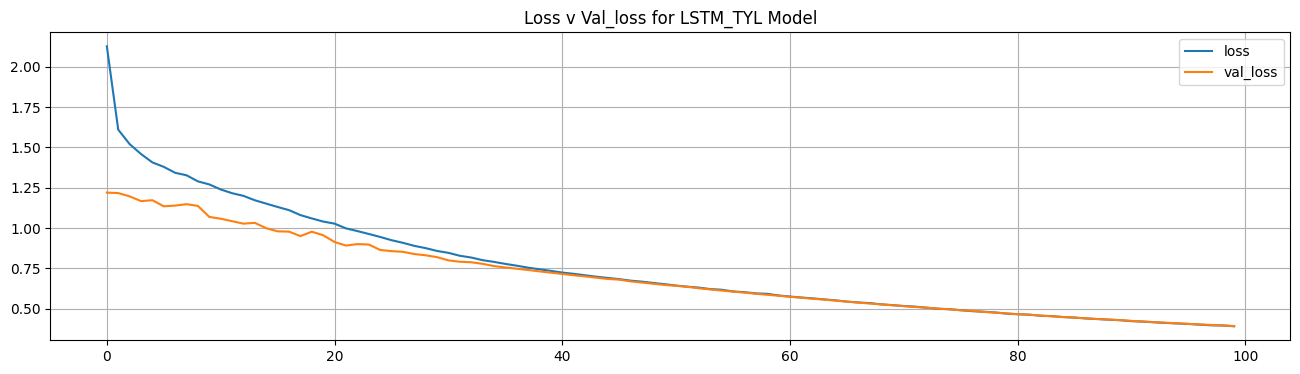

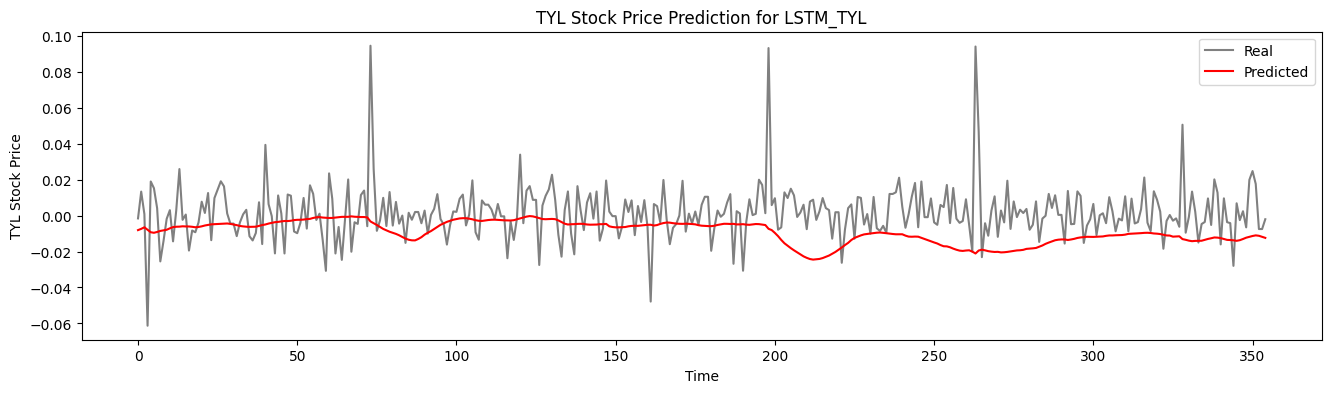

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for TYL

Processing stock: AAPL
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


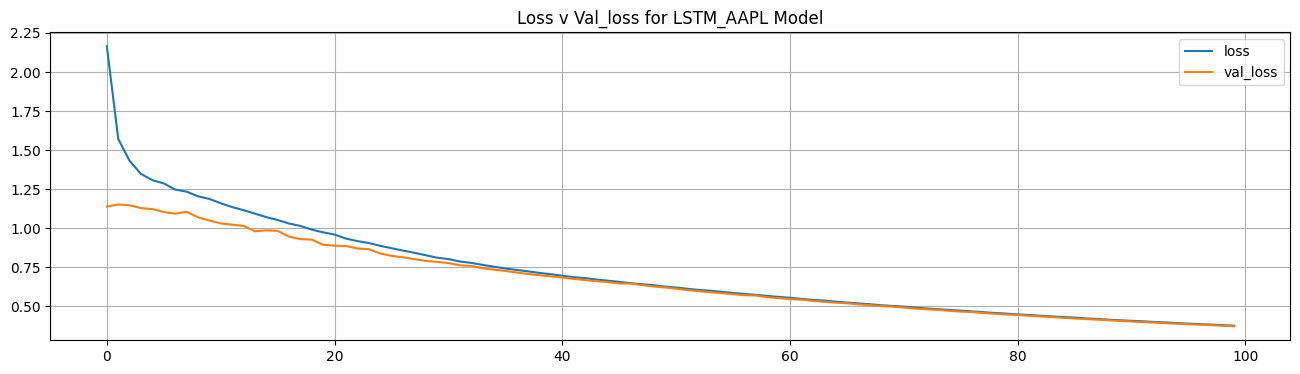

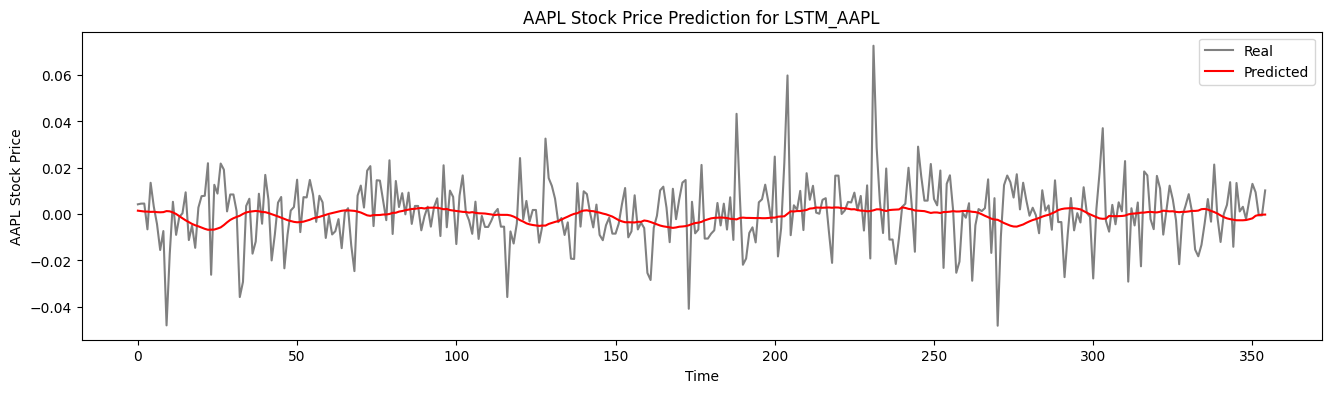

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for AAPL

Processing stock: MSFT
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


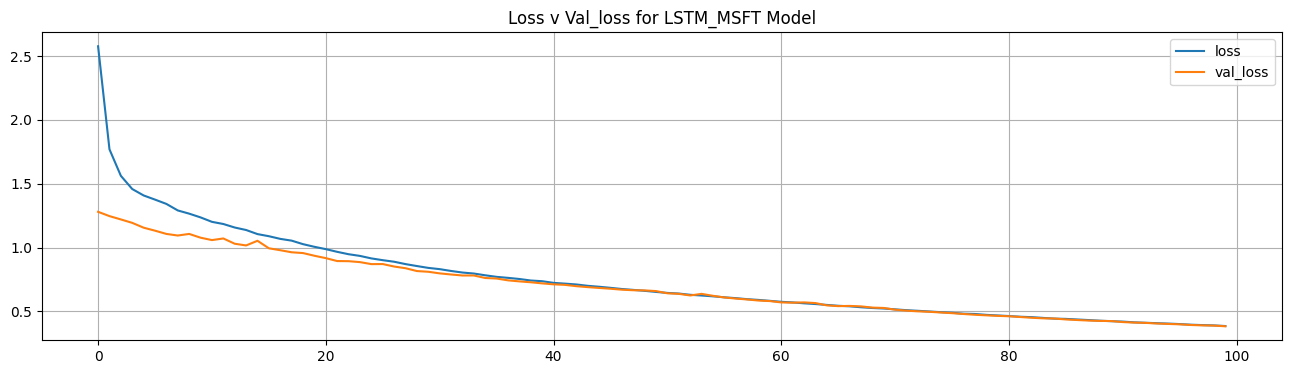

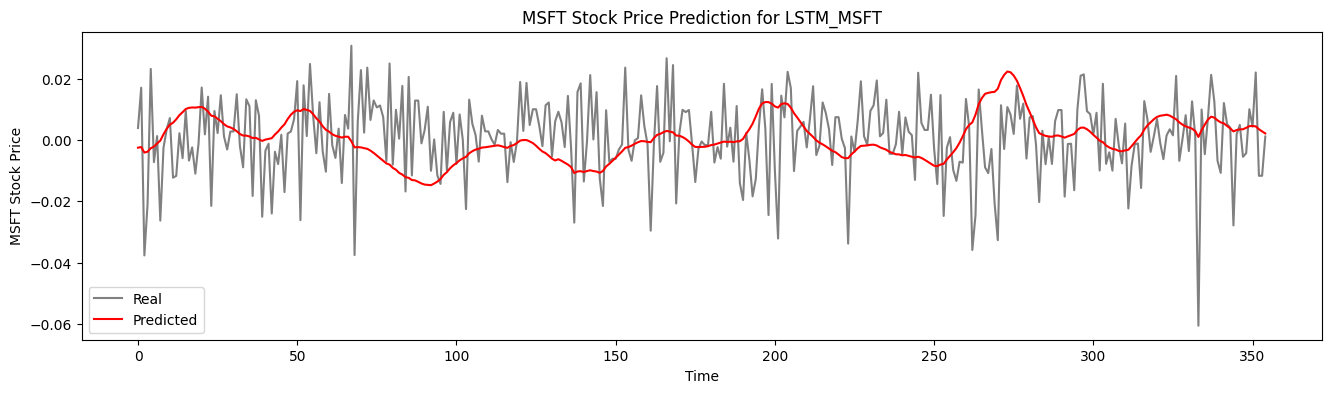

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for MSFT

Processing stock: NVDA
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


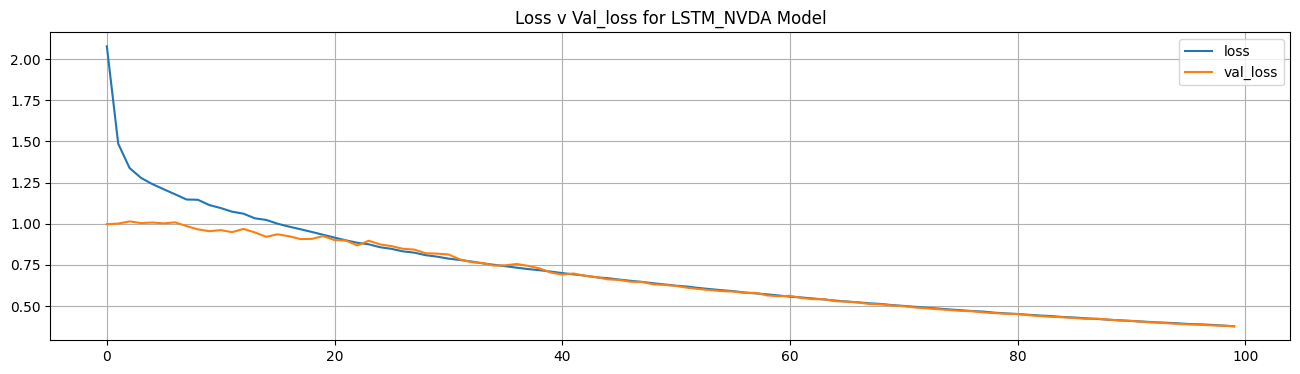

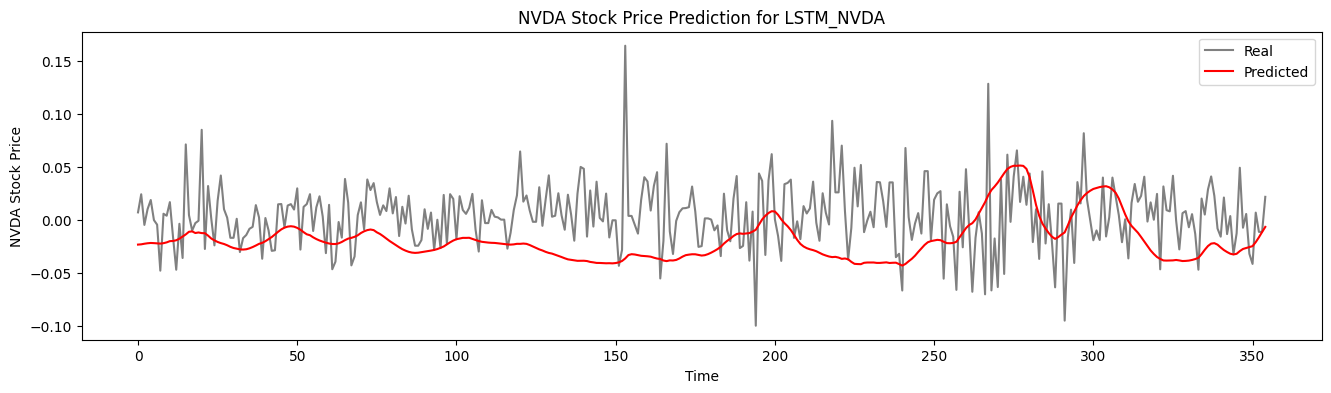

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for NVDA

Processing stock: CRM
Training set size: (1302, 21)
Test set size: (434, 21)
Validation set size: (435, 21)
process complete
Model built and compiled successfully!
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


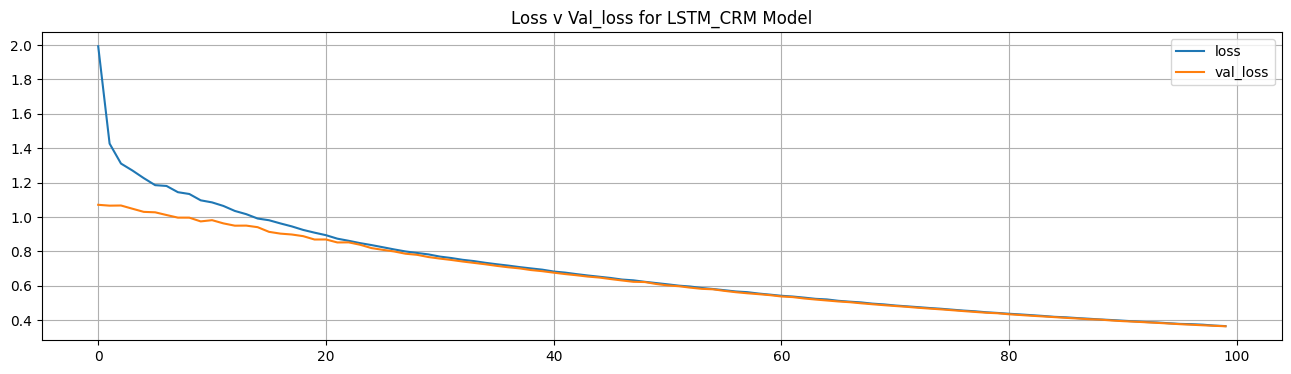

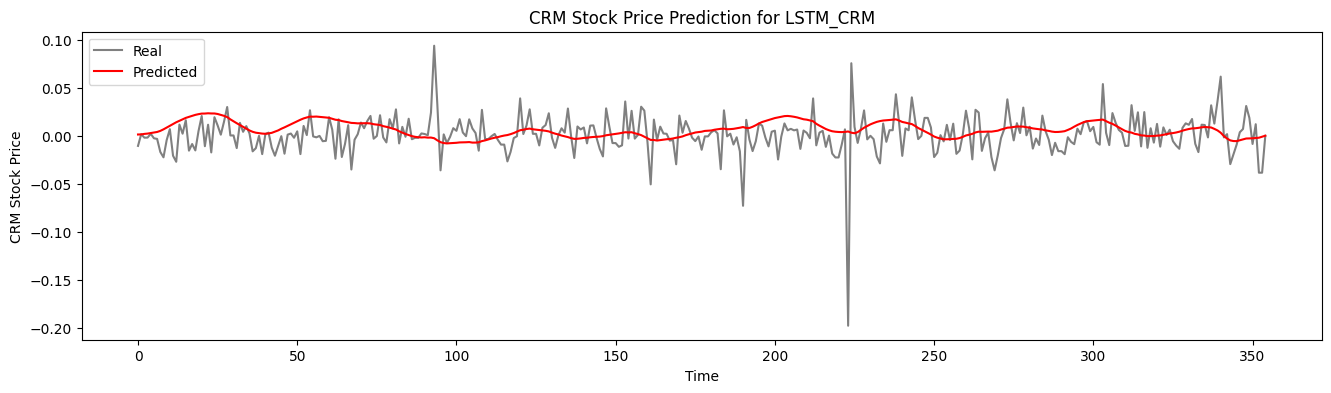

Predictions saved. Access via `self.predicted_values` and `self.actual_values`.
Completed processing for CRM


In [ ]:
# Dictionary to store results
stock_results = []

for ticker in stock_tickers:
    print(f"\nProcessing stock: {ticker}")

    # Initialize and train the model
    model_instance = myModel(ticker, df )
    history_df = model_instance.training(epochs=100, batch_size=128, verbose=0, title_=f"LSTM_{ticker}")

    # Evaluate and save predictions
    model_instance.evaluate()

    # # Store last 40 rows of predicted and actual values
    # last_40 = pd.DataFrame({
    #     'Actual': list(model_instance.actual_values[-40:]),
    #     'Predicted': list(model_instance.predicted_values[-40:])
    # })

    stock_results.append(model_instance.export_df.copy())

    print(f"Completed processing for {ticker}")

In [ ]:
# Combine results into a single DataFrame for all stocks
all_results_df = pd.concat(stock_results, axis = 0 )

# Save to CSV (optional)
all_results_df.to_csv("/content/drive/MyDrive/results_36_lstm.csv", index=False)
print(f"CSV saved to_")

CSV saved to_


In [ ]:
# Evaluate the model and save results
# model_instance.evaluate()